# Stochastic Optimization with Heavy-Tailed Noise via Accelerated Gradient Clipping
## Experiments with CNNs of CIFAR10

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch import Tensor
from torch.optim import Optimizer
from typing import List, Optional
from tqdm.auto import tqdm
import scipy
from scipy import stats
from copy import deepcopy
from matplotlib.gridspec import GridSpec
import bisect

Utility functions

In [2]:
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.247, 0.2435, 0.2616],
)

In [3]:
def samplers(n, split_shuffle=True, val_size=0.1):
    if split_shuffle:
        idx = torch.randperm(n, generator=torch.Generator().manual_seed(0))
    else:
        idx = torch.arange(n)
    split_idx = int((1.0 - val_size) * n)
    train_sampler = SubsetRandomSampler(idx[:split_idx])
    val_sampler = SubsetRandomSampler(idx[split_idx:])
    return train_sampler, val_sampler

In [4]:
def train_val_dataloader(root_dir='./cifar10', split_shuffle=True, val_size=0.1, batch_size=128):
    train_dataset = CIFAR10(root=root_dir, train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))
    val_dataset = CIFAR10(root=root_dir, train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))


    train_sampler, val_sampler = samplers(len(train_dataset), split_shuffle, val_size)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)
    return train_dataloader, val_dataloader


In [5]:
def test_dataloader(root_dir='./cifar10', batch_size=128):
    test_dataset = CIFAR10(root=root_dir, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    return test_dataloader

In [6]:
def train_batch(model, x_batch, y_batch, loss_fn, optimizer):
    model.train()
    model.zero_grad()
    output = model(x_batch)
    loss = loss_fn(output, y_batch)
    loss.backward()
    optimizer.step()
    batch_loss = loss.cpu().item()
    with torch.no_grad():
        batch_acc_sum = (output.argmax(dim=1) == y_batch).sum().cpu().item()
    return batch_loss, batch_acc_sum


In [7]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    epoch_loss = 0.0
    epoch_acc = 0
    epoch_size = 0
    for i_batch, (X_batch, y_batch) in enumerate(dataloader):
        batch_loss, batch_acc_sum = train_batch(model, X_batch.to(model.device), y_batch.to(model.device), loss_fn, optimizer)
        epoch_size += len(X_batch)
        epoch_loss += batch_loss * len(X_batch)
        epoch_acc += batch_acc_sum
    epoch_loss /= epoch_size
    epoch_acc /= epoch_size
    return epoch_loss, epoch_acc


In [8]:
def train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs, callback=None):
    epochs = tqdm(range(n_epochs), desc='Epochs', leave=True)
    for i_epoch in epochs:
        epoch_loss, epoch_acc = train_epoch(model, train_dataloader, loss_fn, optimizer)
        if callback is not None:
            cb_dict = callback(model, val_dataloader, loss_fn, epoch_loss, epoch_acc)
            epochs.set_postfix(cb_dict)

In [9]:
def evaluate(model, dataloader, loss_fn):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            output = model(X_batch.to(model.device)).cpu()
            logits.append(output)
            targets.append(y_batch)
    logits = torch.cat(logits)
    targets = torch.cat(targets)
    loss = loss_fn(logits, targets).item()
    acc = (logits.argmax(dim=1) == targets).sum().item() / len(targets)
    return loss, acc


In [10]:
class CallBack:
    def __init__(self, eval_fn, name=None):
        self.eval_fn = eval_fn
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []

    def last_info(self):
        return {'loss_train': f'{self.train_losses[-1]}',
                'acc_train': f'{self.train_accs[-1]}',
                'loss_val': f'{self.val_losses[-1]}',
                'acc_val': f'{self.val_accs[-1]}'}

    def __call__(self, model, val_dataloader, loss_fn,
                 epoch_loss=None, epoch_acc=None):
        self.train_losses.append(epoch_loss)
        self.train_accs.append(epoch_acc)
        loss_val, acc_val = self.eval_fn(model, val_dataloader, loss_fn)
        self.val_losses.append(loss_val)
        self.val_accs.append(acc_val)
        return self.last_info()

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

Data loading

In [13]:
train_dataloader, val_dataloader = train_val_dataloader()
test_loader = test_dataloader()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

100%|██████████| 170498071/170498071 [00:03<00:00, 43705042.43it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified
Files already downloaded and verified


In [14]:
device

device(type='cuda')

# Optimizers

Let's implement clipped SGD and clipped SSTM from source paper.

In [15]:
def clipped_gradent_descent_step(
        params: List[Tensor],
        d_p_list: List[Tensor],
        momentum_buffer_list: List[Optional[Tensor]],
        lr: float,
        momentum: float,
        clipping_type: str,
        clipping_level: float):
    grad_norm = 0.0
    if clipping_type == 'norm':
        for i in range(len(params)):
            grad_norm += d_p_list[i].norm() ** 2
        grad_norm = grad_norm ** 0.5

    for i, param in enumerate(params):
        d_p = d_p_list[i]

        if momentum != 0:
            buf = momentum_buffer_list[i]

            if buf is None:
                buf = torch.clone(d_p).detach()
                momentum_buffer_list[i] = buf
            else:
                buf.mul_(momentum).add_(d_p, alpha=1)

            d_p = buf

        if clipping_type == 'no_clip':
            param.add_(d_p, alpha=-lr)
        elif clipping_type == 'norm':
            alpha = min(1, clipping_level / grad_norm)
            param.add_(d_p, alpha=-lr*alpha)
        elif clipping_type == 'layer_wise':
            alpha = min(1, clipping_level / d_p.norm())
            param.add_(d_p, alpha=-lr*alpha)
        elif clipping_type == 'coordinate_wise':
            eps = 1e-8
            alpha = torch.clip(clipping_level / (torch.abs(d_p) + eps), min=0, max=1)
            param.add_(-lr * alpha * d_p)


class _RequiredParameter(object):
    def __repr__(self):
        return "<required parameter>"

required = _RequiredParameter()


class _DependingParameter(object):
    def __init__(self, other_parameter_name):
        self.other_parameter_name = other_parameter_name

    def __repr__(self):
        return "<depends on {}>".format(self.other_parameter_name)

depending = _DependingParameter


class clipped_SGD(Optimizer):
    def __init__(
        self, params,
        lr=required,
        momentum=0,
        clipping_type='norm', clipping_level=depending('clipping_type')
    ):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        type_to_default_level = {
            'no_clip': 0.0,
            'norm': 1.0,
            'layer_wise': 0.3,
            'coordinate_wise': 0.1
        }
        if clipping_type not in type_to_default_level:
            raise ValueError("Invalid clipping type: {}, possible types are {}".\
                             format(lr, list(type_to_default_level.keys())))
        if not isinstance(clipping_level, depending) and clipping_level < 0.0:
            raise ValueError("Invalid clipping level: {}".format(clipping_level))
        if isinstance(clipping_level, depending):
            clipping_level = type_to_default_level[clipping_type]
        defaults = dict(
            lr=lr,
            momentum=momentum,
            clipping_type=clipping_type, clipping_level=clipping_level
        )
        super(clipped_SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(clipped_SGD, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            momentum_buffer_list = []
            lr = group['lr']
            momentum = group['momentum']
            clipping_type = group['clipping_type']
            clipping_level = group['clipping_level']

            for p in group['params']:
                if p.grad is not None:
                    d_p_list.append(p.grad)
                    params_with_grad.append(p)

                    state = self.state[p]
                    if 'momentum_buffer' not in state:
                        momentum_buffer_list.append(None)
                    else:
                        momentum_buffer_list.append(state['momentum_buffer'])
            clipped_gradent_descent_step(
                params_with_grad,
                d_p_list,
                momentum_buffer_list,
                lr,
                momentum,
                clipping_type,
                clipping_level
            )
            for p, momentum_buffer in zip(params_with_grad, momentum_buffer_list):
                state = self.state[p]
                state['momentum_buffer'] = momentum_buffer

        return loss


class clipped_SSTM(Optimizer):
    def __init__(
        self, params,
        lr=required, L=required,
        clipping_type='norm', clipping_level=depending('clipping_type'),
        nu=1, a_k_ratio_upper_bound=1.0, clipping_iter_start=None
    ):
        if lr is not required and lr <= 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if L is not required and L < 0.0:
            raise ValueError("Invalid Lipschitz constant: {}".format(lr))

        type_to_default_level = {
            'no_clip': 0.0,
            'norm': 1.0,
            'layer_wise': 0.3,
            'coordinate_wise': 0.1
        }
        if clipping_type not in type_to_default_level:
            raise ValueError("Invalid clipping type: {}, possible types are {}".\
                             format(clipping_type, list(type_to_default_level.keys())))
        if not isinstance(clipping_level, depending) and clipping_level < 0.0:
            raise ValueError("Invalid clipping level: {}".format(clipping_level))
        if isinstance(clipping_level, depending):
            clipping_level = type_to_default_level[clipping_type]
        if nu < 0.0 or nu > 1.0:
            raise ValueError("Invalid nu: {}".format(nu))
        if a_k_ratio_upper_bound <= 0.0 or a_k_ratio_upper_bound > 1.0:
            raise ValueError("Invalid a_k_ratio_upper_bound: {}".format(a_k_ratio_upper_bound))
        if clipping_iter_start is not None:
            if not isinstance(clipping_iter_start, int) or clipping_iter_start <= 0:
	            raise ValueError("Invalid clipping_iter_start: {}, should be positive integer")
            if (nu > 0 and clipping_type == 'norm'):
                a = 1 / lr
                clipping_level = 1 / (2 * a * L) * (clipping_iter_start + 1) ** (2 * nu / (1 + nu))
            elif (nu < 1e-4):
                a = 1 / lr
                clipping_level = clipping_level / (2 * a * L)

        defaults = dict(
            lr=lr, L=L,
            clipping_type=clipping_type, clipping_level=clipping_level,
            nu=nu, a_k_ratio_upper_bound=a_k_ratio_upper_bound,
            state=dict()
        )
        super(clipped_SSTM, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(clipped_SSTM, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            a = 1 / group['lr']
            L = group['L']
            clipping_type = group['clipping_type']
            clipping_level = group['clipping_level']
            nu = group["nu"]
            a_k_ratio_upper_bound = group["a_k_ratio_upper_bound"]

            state = group['state']
            if len(state) == 0:
                state['k'] = 0
                state['alpha_k_1'] = 0
                state['lambda_k_1'] = 0
                state['A_k'] = 0
                state['A_k_1'] = 0

                state['y_k'] = []
                state['z_k'] = []
                for p in group['params']:
                    if p.grad is not None:
                        state['y_k'].append(p.detach().clone())
                        state['z_k'].append(p.detach().clone())

            k = state['k']
            alpha_k_1 = state['alpha_k_1']
            lambda_k_1 = state['lambda_k_1']
            A_k = state['A_k']
            A_k_1 = state['A_k_1']
            y_k = [y.detach().clone() for y in state['y_k']]
            z_k = [z.detach().clone() for z in state['z_k']]

            if k > 0:
                for p in group['params']:
                    if p.grad is not None:
                        d_p_list.append(p.grad.data)


                clipped_gradent_descent_step(
                    z_k,
                    d_p_list,
                    None,
                    alpha_k_1,
                    0,
                    clipping_type,
                    lambda_k_1
                )


                i = 0
                for p in group['params']:
                    if p.grad is not None:
                        y_k[i].data = (A_k * y_k[i].data + alpha_k_1 * z_k[i].data) / A_k_1
                        i += 1


            alpha_k_1 = 1 / (2 * a * L) * (k + 1) ** (2 * nu / (1 + nu))

            A_k = state['A_k_1']
            A_k_1 = A_k + alpha_k_1


            if a_k_ratio_upper_bound < 1.0:
                ratio_mul_factor = 1.0 / (1.0 - a_k_ratio_upper_bound)
                if A_k > ratio_mul_factor * alpha_k_1:
                    A_k = (ratio_mul_factor - 1.0) * alpha_k_1
                    A_k_1 = ratio_mul_factor * alpha_k_1

            lambda_k_1 = clipping_level / alpha_k_1


            state['y_k'] = y_k
            state['z_k'] = z_k


            i = 0
            for p in group['params']:
                if p.grad is not None:
                    p.data = (A_k * state['y_k'][i].data + alpha_k_1 * state['z_k'][i].data) / A_k_1
                    i += 1

            state['k'] += 1
            state['alpha_k_1'] = alpha_k_1
            state['lambda_k_1'] = lambda_k_1
            state['A_k'] = A_k
            state['A_k_1'] = A_k_1

        return loss

In [16]:
def get_batch_grad(model):
    gr=[]
    for i in model.parameters():
        if i.requires_grad:
            gr.append(i.grad.view(-1))
    return torch.cat(gr)


def get_loss(model, criterion, batch):
    inputs, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    return loss


def compute_full_grad(model, optimizer, criterion, dataloader_for_full_grad):
    fully_grad = []
    optimizer.zero_grad()

    print("Computing full gradient")
    with tqdm(total=len(dataloader_for_full_grad)) as pbar:
        for step, batch in enumerate(dataloader_for_full_grad):
            loss = get_loss(model, criterion, batch)
            loss.backward()

            if fully_grad != []:
                fully_grad = fully_grad + get_batch_grad(model) * \
                    dataloader_for_full_grad.batch_size
            else:
                fully_grad = get_batch_grad(model) * dataloader_for_full_grad.batch_size
            optimizer.zero_grad()

            pbar.update(1)

    return fully_grad / (step * dataloader_for_full_grad.batch_size)


def compute_norm_diffs(model, optimizer, criterion, dataloader_for_full_grad, dataloader, full_grad=None, repeats=1):
    if full_grad is None:
        full_grad = compute_full_grad(model, optimizer, criterion, dataloader_for_full_grad)
    mini_norms = []
    optimizer.zero_grad()

    print("Computing norm diffs")
    with tqdm(total=repeats * len(dataloader)) as pbar:
        for _ in range(repeats):
            for step, batch in enumerate(dataloader):
                loss = get_loss(model, criterion, batch)
                loss.backward()

                mini_norms.append((get_batch_grad(model) - full_grad).norm().item())
                optimizer.zero_grad()

                pbar.update(1)

    return np.array(mini_norms)

def get_loss(model, criterion, batch):
    inputs, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    return loss

def recursive_to(param, device):
    if isinstance(param, torch.Tensor):
        param.data = param.data.to(device)
        if param._grad is not None:
            param._grad.data = param._grad.data.to(device)
    elif isinstance(param, dict):
        for subparam in param.values():
            recursive_to(subparam, device)
    elif isinstance(param, list):
        for subparam in param:
            recursive_to(subparam, device)

def optimizer_to(optim, device):
    for param_group in optim.param_groups:
        for param in param_group.values():
            recursive_to(param, device)


In [17]:
torch.manual_seed(1337)

In [18]:
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred)).contiguous()
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def smooth(a, eps=0.01):
    b = [a[0]]
    for e in a[1:]:
        b.append(b[-1] * (1 - eps) + e * eps)
    return b


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def group_uniques(hist, one_optim_hist, group_unique, loss_name):
    if not group_unique:
        return one_optim_hist[loss_name]
    else:
        res = [0] * len(one_optim_hist[loss_name])
        unique_name = one_optim_hist["name"]
        k = 0
        for one_optim_hist in hist:
            if one_optim_hist["name"] == unique_name:
                k += 1
                for i, elem in enumerate(one_optim_hist[loss_name]):
                    res[i] += elem
        res = [elem / k for elem in res]
        return res


def make_loss_plot(ax, hist, eps=0.01, alpha=0.5, make_train=True, make_val=True, starting_epoch=0, group_unique=False, loss_name="logloss"):
    if len(hist) < 7:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    else:
        cmap = plt.get_cmap('hsv')
        colors = cmap(np.linspace(0, 0.9, len(hist)))
    unique_tried = {}
    for one_optim_hist in hist:
        unique_tried[one_optim_hist["name"]] = False

    for i, one_optim_hist in enumerate(hist):
        label = one_optim_hist["name"]

        if group_unique and unique_tried[label]:
            continue
        unique_tried[label] = True

        if len(one_optim_hist["train_x"]) == 0:
            continue

        epochs_x = one_optim_hist["epochs_x"][starting_epoch:]
        start = int(epochs_x[0])

        if make_train:
            train_y = group_uniques(hist, one_optim_hist, group_unique, "train_loss")
            smoothed_train_y = smooth(train_y, eps=eps)[start:]
            train_x = one_optim_hist["train_x"][start:]
            ax.plot(
                train_x, smoothed_train_y,
                label=label + " (train)",
                alpha=alpha, color=colors[i], linestyle="-"
            )

        if make_val and len(one_optim_hist["val_x"]) > 0:
            val_y = group_uniques(hist, one_optim_hist, group_unique, "val_loss")
            val_x = one_optim_hist["val_x"]
            ind = bisect.bisect_left(val_x, start)
            ax.plot(
                val_x[ind:], val_y[ind:],
                label=label + " (val)",
                alpha=alpha, color=colors[i], linestyle="--"
            )

        for x in epochs_x:
            ax.axvline(x, linestyle="--", color=colors[i], alpha=0.2)

    if make_train and make_val:
        ax.set_title("{} on train/val with different optimizers".format(loss_name))
    elif make_train:
        ax.set_title("{} on train with different optimizers".format(loss_name))
    elif make_val:
        ax.set_title("{} on val with different optimizers".format(loss_name))
    ax.set_ylabel("{}".format(loss_name))
    ax.set_xlabel("Iteration")
    ax.grid(True)
    ax.legend()

    return ax


def make_metrics_plot(ax, hist, eps=0.01, alpha=0.5, make_train=True, make_val=True, starting_epoch=0, metric_name="acc_top_1", title="top-1 accuracy"):
    if len(hist) < 7:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    else:
        cmap = plt.get_cmap('hsv')
        colors = cmap(np.linspace(0, 0.9, len(hist)))

    for i, one_optim_hist in enumerate(hist):
        label = one_optim_hist["name"]

        if len(one_optim_hist["train_x"]) == 0:
            continue

        epochs_x = one_optim_hist["epochs_x"][starting_epoch:]
        start = int(epochs_x[0])

        if make_train:
            train_acc_top = one_optim_hist["train_{}".format(metric_name)]
            smoothed_train_acc_top = smooth(train_acc_top, eps=eps)[start:]
            train_x = one_optim_hist["train_x"][start:]
            ax.plot(
                train_x, smoothed_train_acc_top,
                label=label + " (train)",
                alpha=alpha, color=colors[i], linestyle="-"
            )

        if make_val and len(one_optim_hist["val_x"]) > 0:
            val_acc_top = one_optim_hist["val_{}".format(metric_name)]
            val_x = one_optim_hist["val_x"]
            ind = bisect.bisect_left(val_x, start)
            ax.plot(
                val_x[ind:], val_acc_top[ind:],
                label=label + " (val)",
                alpha=alpha, color=colors[i], linestyle="--"
            )

        for x in epochs_x:
            ax.axvline(x, linestyle="--", color=colors[i], alpha=0.2)


    if make_train and make_val:
        ax.set_title("{} on train/val".format(title))
    elif make_train:
        ax.set_title("{} on train".format(title))
    elif make_val:
        ax.set_title("{} on val".format(title))

    ax.set_ylabel("{}".format(title))
    ax.set_xlabel("Iteration")
    ax.grid(True)

    return ax


def make_accuracy_plot(ax, hist, eps=0.01, alpha=0.5, top_k=1, make_train=True, make_val=True, starting_epoch=0):
    return make_metrics_plot(ax, hist, eps, alpha, make_train, make_val, starting_epoch, metric_name="acc_top_{}".format(top_k), title="top-{} accuracy".format(top_k))


def make_plot(
    ax, hist, y_name, x_name,
    title="logloss with different optimizers", y_label="logloss", x_label="iteration",
    eps=0.01, alpha=0.5, starting_epoch=0, draw_epoch_lines=True, grid=True, legend=True,
    mark_every_count=15, title_fontsize=14, xy_label_fontsize=10,
    line_params={}
):
    if len(hist) < 7:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    else:
        cmap = plt.get_cmap('hsv')
        colors = cmap(np.linspace(0, 0.9, len(hist)))

    for i, one_optim_hist in enumerate(hist):
        label = one_optim_hist["name"]
        if label in line_params:
            line_style = line_params[label]["line_style"]
            line_color = line_params[label]["line_color"]
            line_marker = line_params[label]["line_marker"]
            mark_every = line_params[label]["mark_every"]
            label = line_params[label]["name"]
        else:
            line_style="-"
            line_color=colors[i]
            line_marker = None
            mark_every = None

        if len(one_optim_hist["epochs_x"]) <= starting_epoch:
            continue

        epochs_x = one_optim_hist["epochs_x"][starting_epoch:]
        start = int(epochs_x[0])

        if len(one_optim_hist[y_name]) == 0:
            continue

        smoothed_y = smooth(one_optim_hist[y_name], eps=eps)
        x = one_optim_hist[x_name]

        ind = bisect.bisect_left(x, start)
        smoothed_y = smoothed_y[ind:]
        x = x[ind:]

        if mark_every == "auto":
            mark_every = len(x) // (mark_every_count + 1)
            mark_every = np.arange((i * mark_every) // (len(hist)), len(x), mark_every)

        ax.plot(
            x, smoothed_y,
            label=label, alpha=alpha, color=line_color, linestyle=line_style,
            marker=line_marker, markevery=mark_every
        )

        if draw_epoch_lines:
            for x in epochs_x:
                ax.axvline(x, linestyle="--", color=line_color, alpha=0.2)

    plt.rc('font', size=xy_label_fontsize)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    ax.set_title(title, fontsize=title_fontsize)
    ax.set_ylabel(y_label, fontsize=xy_label_fontsize)
    ax.set_xlabel(x_label, fontsize=xy_label_fontsize)
    ax.grid(grid)
    if legend:
        ax.legend()

    return ax


def draw_norm_hist(ax, norm_diffs, bins_n=100, draw_normal=True):
    counts, bins = np.histogram(norm_diffs, bins_n, density=True)

    if draw_normal:
        mu = np.mean(norm_diffs)
        sigma = np.sqrt(np.mean((norm_diffs - mu)**2))
        temp2 = np.linspace(bins[0], bins[-1], bins_n)
        y = scipy.stats.norm.pdf(temp2, mu, sigma)
        temp2 = temp2[y > (counts[counts > 0]).min()]

        ax.plot(
            temp2, scipy.stats.norm.pdf(temp2, mu, sigma),
            linewidth=2, color='red'
        )

    ax.hist(bins[:-1], bins, weights=counts)

    return ax


def draw_norm_hists_for_different_models(fig, subplotspec_outer, hist, bins_n=100, draw_normal=True, number=-1):
    h = (len(hist) + 2) // 3
    sgs = subplotspec_outer.subgridspec(h, 3, wspace=0.15, hspace=0.25)
    for (i, one_optim_hist) in enumerate(hist):
        ax = fig.add_subplot(sgs[i // 3, i % 3])
        if len(one_optim_hist["norm_diffs"]) > 0:
            ax = draw_norm_hist(ax, one_optim_hist["norm_diffs"][number], bins_n=bins_n, draw_normal=draw_normal)
            label = one_optim_hist["name"]
            ax.set_title("{},\n batch_count={}, skew={:0.2f}".format(
                label,
                len(one_optim_hist["norm_diffs"][number]),
                stats.skew(one_optim_hist["norm_diffs"][number])
            ), fontsize=11)
        ax.set_ylabel("Density")
        ax.set_xlabel("Noise norm")
        ax.grid(True)

    ax = plt.Subplot(fig, subplotspec_outer)
    ax.set_title("Distribution of the gradient noise for different optimizers", y=1.15, fontsize=14)
    ax.set_frame_on(False)
    ax.axis('off')
    fig.add_subplot(ax)

    return ax


def draw_norm_hists_for_one_model(
    ax, hist,
    title, y_label="density", x_label="noise norm",
    bins_n=100, draw_normal=True, number=-1, grid=True,
    add_batch_count=True, round_batch_count=True,
    title_fontsize=14, xy_label_fontsize=10
):
    one_optim_hist = hist[0]
    ax = draw_norm_hist(ax, one_optim_hist["norm_diffs"][number], bins_n=bins_n, draw_normal=draw_normal)

    batch_count = len(one_optim_hist["norm_diffs"][number])
    if round_batch_count:
        batch_count = "~{}k".format(batch_count // 1000)
    if add_batch_count:
        title = "{}, batch count={}".format(title, batch_count)

    ax.set_title(title, fontsize=title_fontsize)
    ax.set_ylabel(y_label, fontsize=xy_label_fontsize)
    ax.set_xlabel(x_label, fontsize=xy_label_fontsize)
    ax.grid(grid)

    return ax


def draw_norm_hists_evolution(fig, subplotspec_outer, one_optim_hist, bins_n=100, draw_normal=True, w=None):
    if w is None:
        w = len(one_optim_hist["norm_diffs"])

    label = one_optim_hist["name"]

    h = (len(one_optim_hist["norm_diffs"]) + w - 1) // w
    sgs = subplotspec_outer.subgridspec(h, w, wspace=0.15, hspace=0.05)
    for (i, norm_diffs) in enumerate(one_optim_hist["norm_diffs"]):
        ax = fig.add_subplot(sgs[i // w, i % w])
        if len(norm_diffs) > 0:
            ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
            step = 500 * i
            if "norm_diffs_x" in one_optim_hist:
                step = one_optim_hist["norm_diffs_x"][i]
            ax.set_title("step = {},\n batch_count={}, skew={:0.2f}".format(
                step, len(norm_diffs), stats.skew(norm_diffs)), fontsize=11)
        ax.set_ylabel("density")
        ax.set_xlabel("noise norm")
        ax.grid(True)

    ax = plt.Subplot(fig, subplotspec_outer)
    ax.set_title("Evolution of the gradient noise for {}".format(label), y=1.15, fontsize=14)
    ax.set_frame_on(False)
    ax.axis('off')
    fig.add_subplot(ax)

    return ax

Consider following architectures

# LeNet

In [19]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.tanh(self.conv1(x))
        out = F.avg_pool2d(out, 2)
        out = F.tanh(self.conv2(out))
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.tanh(self.fc1(out))
        out = F.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

In [20]:
model = LeNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
cb_sgd = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_sgd, n_epochs=15, callback=cb_sgd)
loss_sgd, acc_sgd = evaluate(model, test_loader, loss_fn)
print(f'LeNet, test loss, SGD: {loss_sgd}')
print(f'LeNet, test accuracy, SGD: {acc_sgd}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

LeNet, test loss, SGD: 1.1565155982971191
LeNet, test accuracy, SGD: 0.5886


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

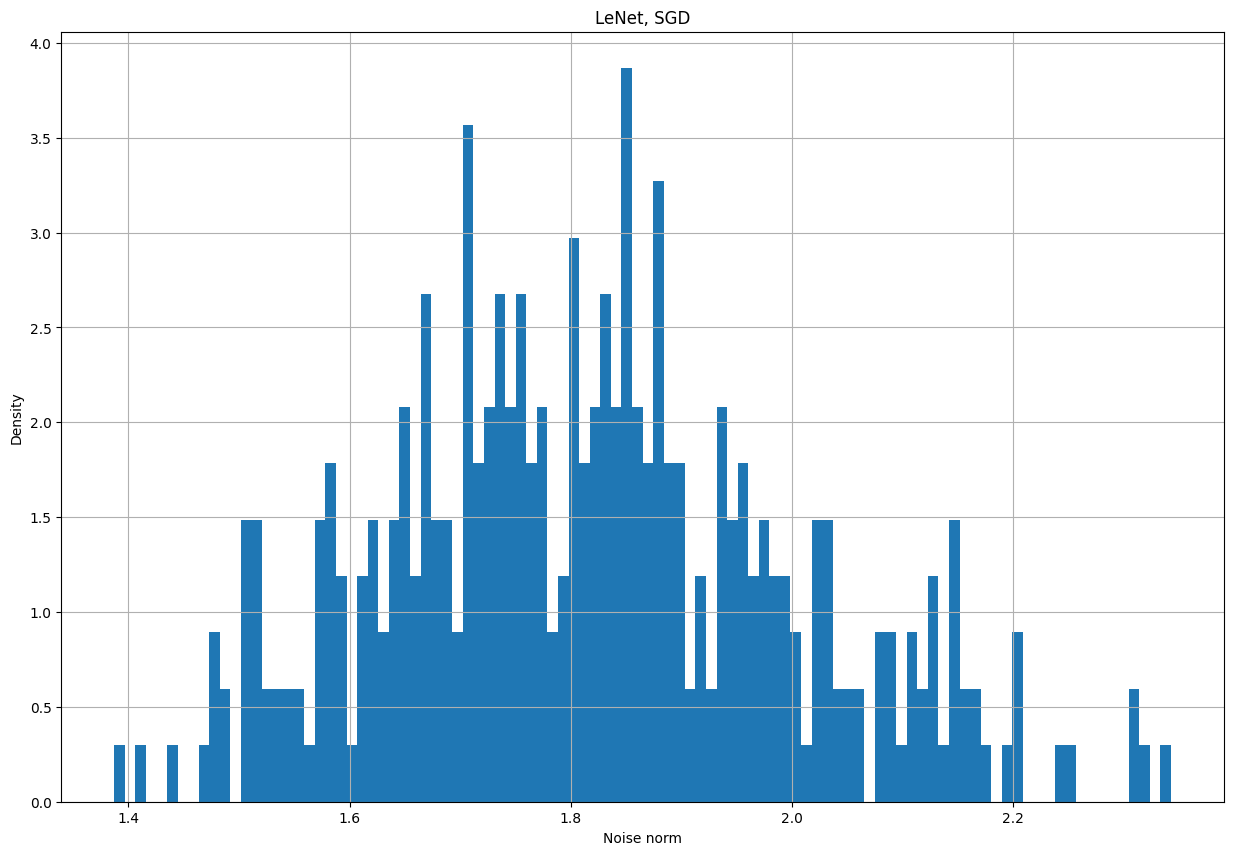

In [21]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_sgd, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('LeNet, SGD')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

In [22]:
model = LeNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(model.parameters(), lr=1e-3)
cb_adam = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_adam, n_epochs=15, callback=cb_adam)
loss_adam, acc_adam = evaluate(model, test_loader, loss_fn)
print(f'LeNet, test loss, Adam: {loss_adam}')
print(f'LeNet, test accuracy, Adam: {acc_adam}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

LeNet, test loss, Adam: 1.2501380443572998
LeNet, test accuracy, Adam: 0.5678


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

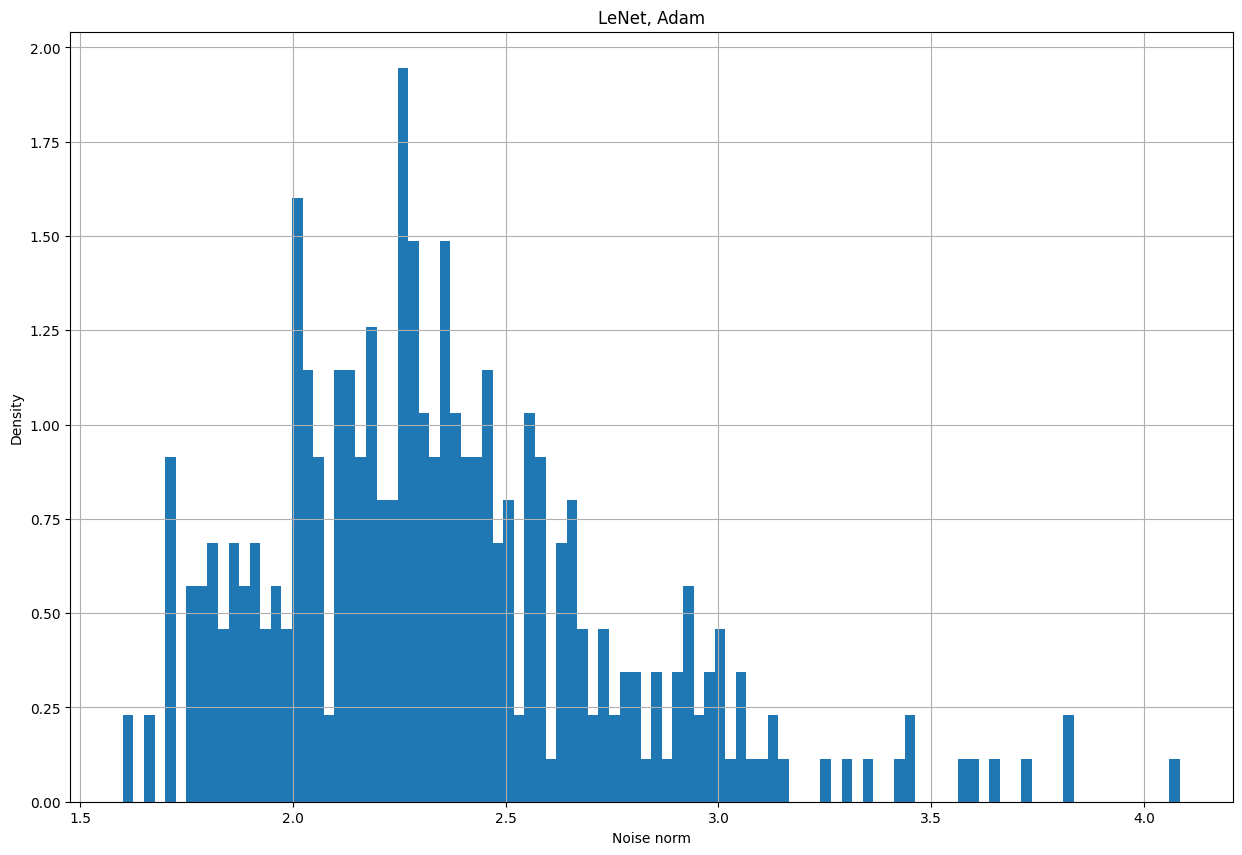

In [23]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_adam, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('LeNet, Adam')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

In [24]:
model = LeNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_clip_sstm = clipped_SSTM(model.parameters(), lr=1e-2, L=10, clipping_type='norm', a_k_ratio_upper_bound=0.99)
cb_clip_sstm = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_clip_sstm, n_epochs=15, callback=cb_clip_sstm)
loss_clip_sstm, acc_clip_sstm = evaluate(model, test_loader, loss_fn)
print(f'LeNet, test loss, Clip SSTM: {loss_clip_sstm}')
print(f'LeNet, test accuracy, Clip SSTM: {acc_clip_sstm}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

LeNet, test loss, Clip SSTM: 1.27247953414917
LeNet, test accuracy, Clip SSTM: 0.5827


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

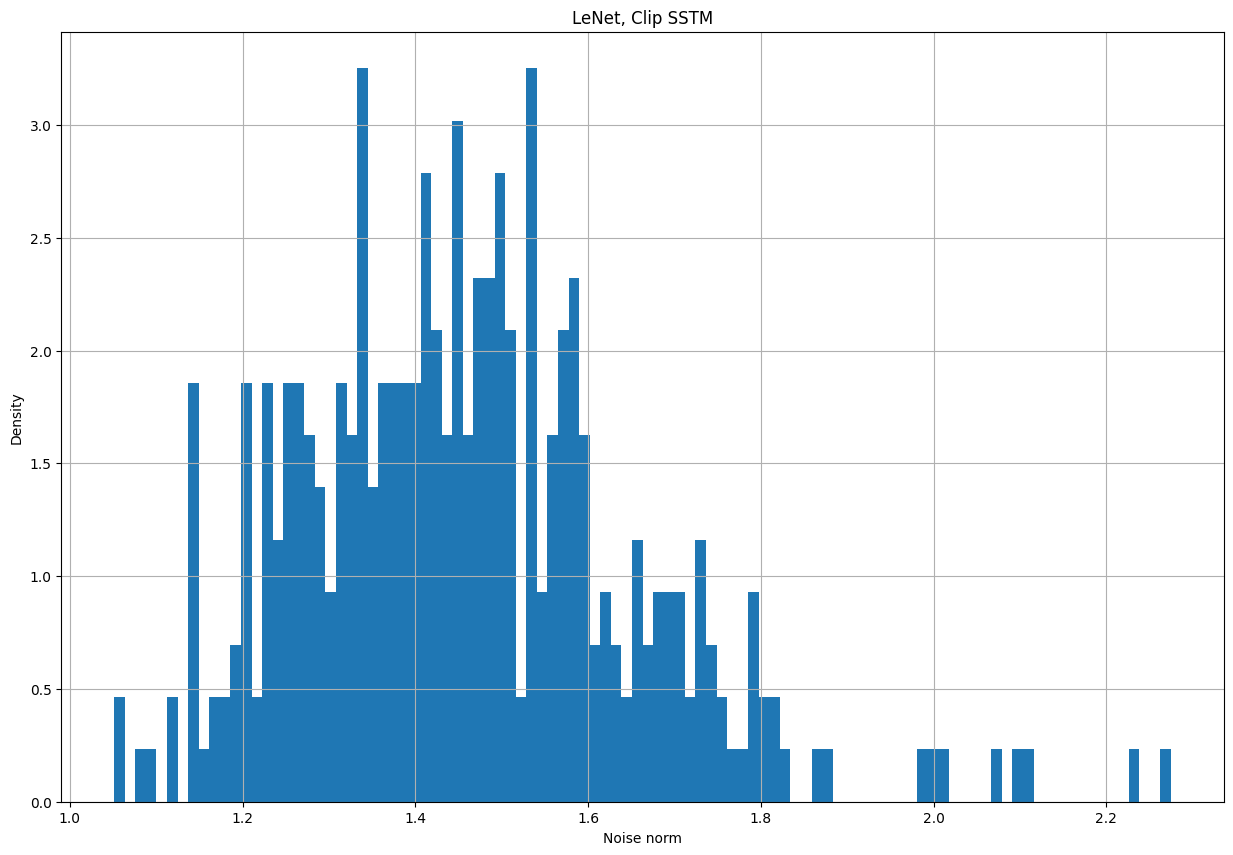

In [25]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_clip_sstm, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('LeNet, Clip SSTM')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

In [26]:
model = LeNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_clip_sgd = clipped_SGD(model.parameters(), lr=5e-2, momentum=0.9, clipping_type="coordinate_wise", clipping_level=0.1)
cb_clip_sgd = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_clip_sgd, n_epochs=15, callback=cb_clip_sgd)
loss_clip_sgd, acc_clip_sgd = evaluate(model, test_loader, loss_fn)
print(f'LeNet, test loss, Clip SGD: {loss_clip_sgd}')
print(f'LeNet, test accuracy, Clip SGD: {acc_clip_sgd}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

LeNet, test loss, Clip SGD: 1.3882113695144653
LeNet, test accuracy, Clip SGD: 0.5463


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

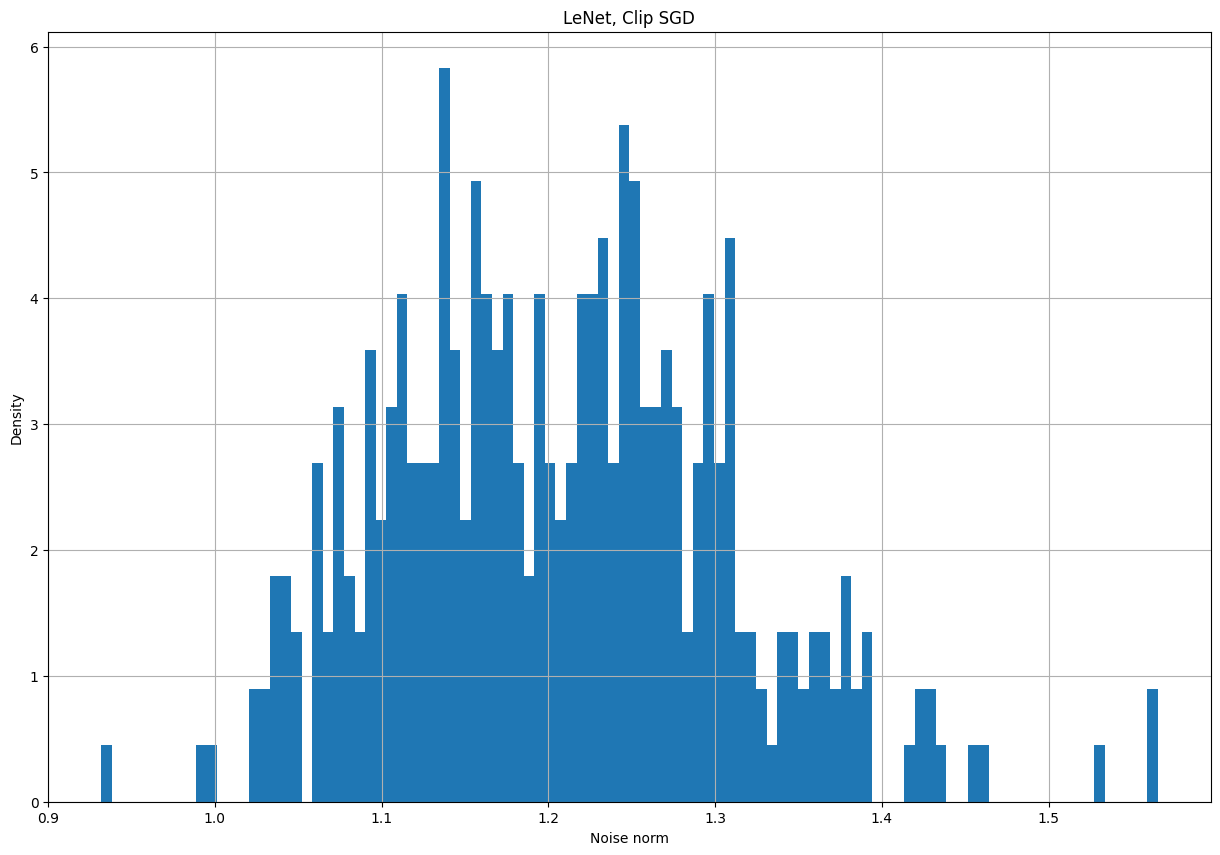

In [27]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_clip_sgd, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('LeNet, Clip SGD')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

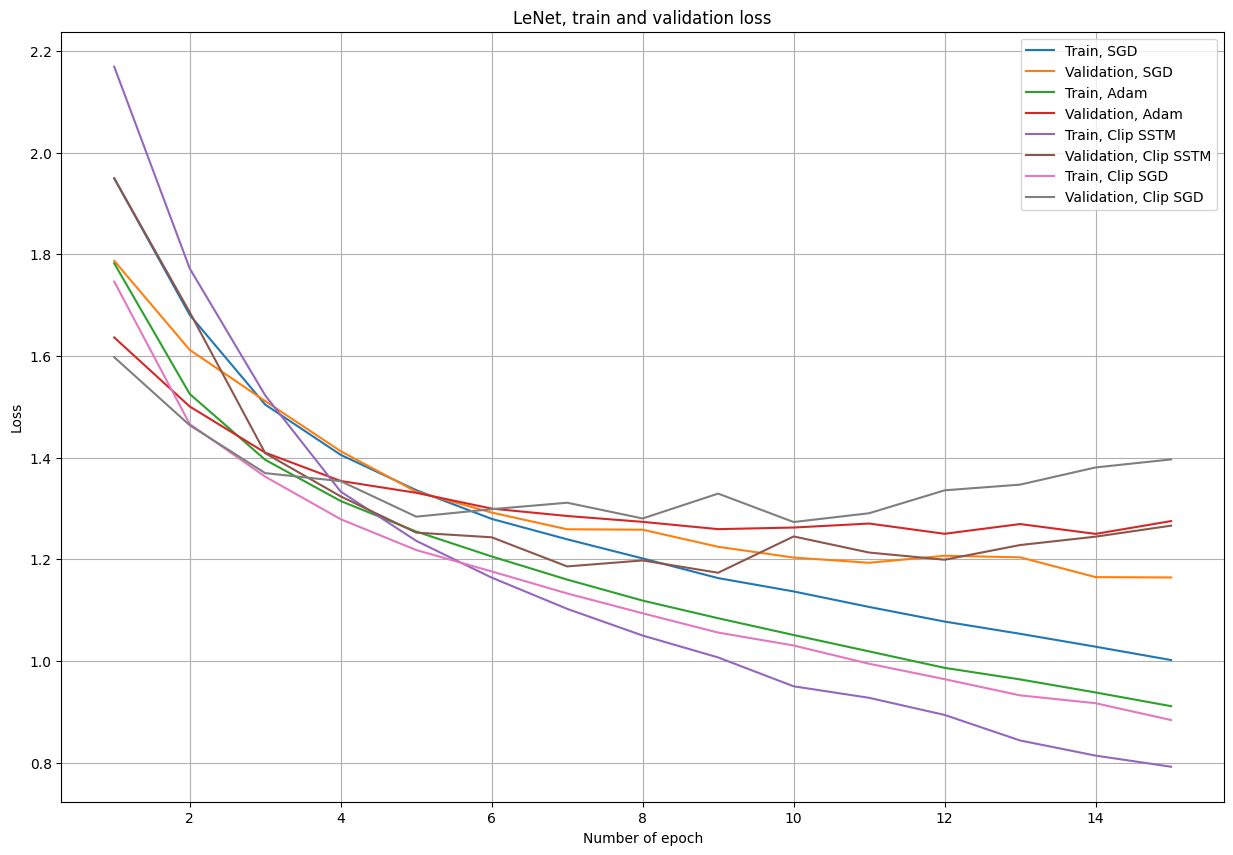

In [28]:
plt.figure(figsize=(15, 10))
plt.title('LeNet, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(15) + 1
plt.plot(epochs, cb_sgd.train_losses, label='Train, SGD')
plt.plot(epochs, cb_sgd.val_losses, label='Validation, SGD')
plt.plot(epochs, cb_adam.train_losses, label='Train, Adam')
plt.plot(epochs, cb_adam.val_losses, label='Validation, Adam')
plt.plot(epochs, cb_clip_sstm.train_losses, label='Train, Clip SSTM')
plt.plot(epochs, cb_clip_sstm.val_losses, label='Validation, Clip SSTM')
plt.plot(epochs, cb_clip_sgd.train_losses, label='Train, Clip SGD')
plt.plot(epochs, cb_clip_sgd.val_losses, label='Validation, Clip SGD')
plt.legend()
plt.grid(True)

In [29]:
print(f'Best loss on train, SGD: {np.min(cb_sgd.train_losses)}, on {np.argmin(cb_sgd.train_losses) + 1} epoch')
print(f'Best loss on validation, SGD: {np.min(cb_sgd.val_losses)}, on {np.argmin(cb_sgd.val_losses) + 1} epoch')
print(f'Best loss on train, Adam: {np.min(cb_adam.train_losses)}, on {np.argmin(cb_adam.train_losses) + 1} epoch')
print(f'Best loss on validation, Adam: {np.min(cb_adam.val_losses)}, on {np.argmin(cb_adam.val_losses) + 1} epoch')
print(f'Best loss on train, Clip SSTM: {np.min(cb_clip_sstm.train_losses)}, on {np.argmin(cb_clip_sstm.train_losses) + 1} epoch')
print(f'Best loss on validation, Clip SSTM: {np.min(cb_clip_sstm.val_losses)}, on {np.argmin(cb_clip_sstm.val_losses) + 1} epoch')
print(f'Best loss on train, Clip SGD: {np.min(cb_clip_sgd.train_losses)}, on {np.argmin(cb_clip_sgd.train_losses) + 1} epoch')
print(f'Best loss on validation, Clip SGD: {np.min(cb_clip_sgd.val_losses)}, on {np.argmin(cb_clip_sgd.val_losses) + 1} epoch')

Best loss on train, SGD: 1.0017682395511203, on 15 epoch
Best loss on validation, SGD: 1.1642193794250488, on 15 epoch
Best loss on train, Adam: 0.9110575107256571, on 15 epoch
Best loss on validation, Adam: 1.2499505281448364, on 14 epoch
Best loss on train, Clip SSTM: 0.7919165524376763, on 15 epoch
Best loss on validation, Clip SSTM: 1.173515796661377, on 9 epoch
Best loss on train, Clip SGD: 0.883735598786672, on 15 epoch
Best loss on validation, Clip SGD: 1.273310661315918, on 10 epoch


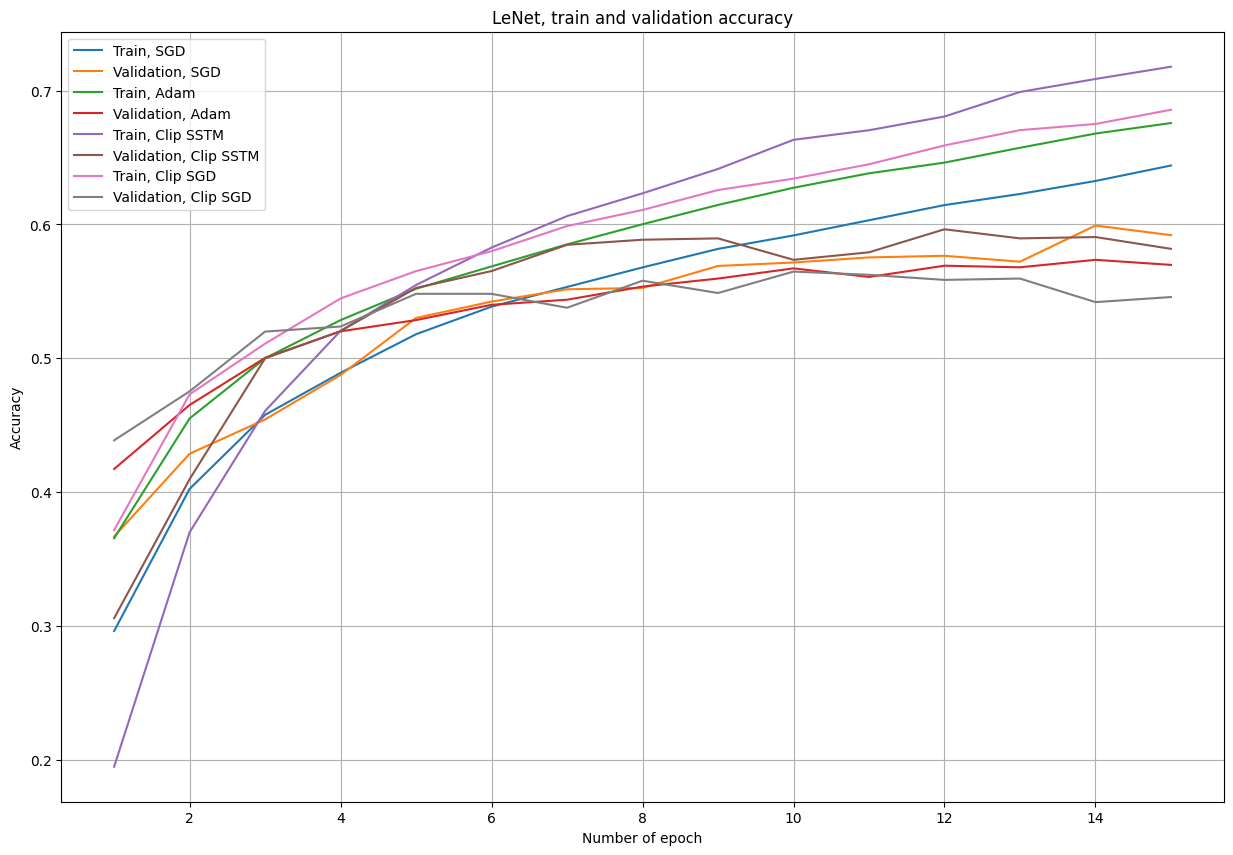

In [30]:
plt.figure(figsize=(15, 10))
plt.title('LeNet, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(15) + 1
plt.plot(epochs, cb_sgd.train_accs, label='Train, SGD')
plt.plot(epochs, cb_sgd.val_accs, label='Validation, SGD')
plt.plot(epochs, cb_adam.train_accs, label='Train, Adam')
plt.plot(epochs, cb_adam.val_accs, label='Validation, Adam')
plt.plot(epochs, cb_clip_sstm.train_accs, label='Train, Clip SSTM')
plt.plot(epochs, cb_clip_sstm.val_accs, label='Validation, Clip SSTM')
plt.plot(epochs, cb_clip_sgd.train_accs, label='Train, Clip SGD')
plt.plot(epochs, cb_clip_sgd.val_accs, label='Validation, Clip SGD')

plt.legend()
plt.grid(True)

In [31]:
print(f'Best accuracy on train, SGD: {np.max(cb_sgd.train_accs)}, on {np.argmax(cb_sgd.train_accs) + 1} epoch')
print(f'Best accuracy on validation, SGD: {np.max(cb_sgd.val_accs)}, on {np.argmax(cb_sgd.val_accs) + 1} epoch')
print(f'Best accuracy on train, Adam: {np.max(cb_adam.train_accs)}, on {np.argmax(cb_adam.train_accs) + 1} epoch')
print(f'Best accuracy on validation, Adam: {np.max(cb_adam.val_accs)}, on {np.argmax(cb_adam.val_accs) + 1} epoch')
print(f'Best accuracy on train, Clip SSTM: {np.max(cb_clip_sstm.train_accs)}, on {np.argmax(cb_clip_sstm.train_accs) + 1} epoch')
print(f'Best accuracy on validation, Clip SSTM: {np.max(cb_clip_sstm.val_accs)}, on {np.argmax(cb_clip_sstm.val_accs) + 1} epoch')
print(f'Best accuracy on train, Clip SGD: {np.max(cb_clip_sgd.train_accs)}, on {np.argmax(cb_clip_sgd.train_accs) + 1} epoch')
print(f'Best accuracy on validation, Clip SGD: {np.max(cb_clip_sgd.val_accs)}, on {np.argmax(cb_clip_sgd.val_accs) + 1} epoch')

Best accuracy on train, SGD: 0.644, on 15 epoch
Best accuracy on validation, SGD: 0.5992, on 14 epoch
Best accuracy on train, Adam: 0.6757333333333333, on 15 epoch
Best accuracy on validation, Adam: 0.5736, on 14 epoch
Best accuracy on train, Clip SSTM: 0.7177777777777777, on 15 epoch
Best accuracy on validation, Clip SSTM: 0.5964, on 12 epoch
Best accuracy on train, Clip SGD: 0.6856222222222222, on 15 epoch
Best accuracy on validation, Clip SGD: 0.5648, on 10 epoch


# AlexNet


In [32]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [33]:
model = AlexNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
cb_sgd = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_sgd, n_epochs=15, callback=cb_sgd)
loss_sgd, acc_sgd = evaluate(model, test_loader, loss_fn)
print(f'AlexNet, test loss, SGD: {loss_sgd}')
print(f'AlexNet, test accuracy, SGD: {acc_sgd}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

AlexNet, test loss, SGD: 1.0360981225967407
AlexNet, test accuracy, SGD: 0.7353


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

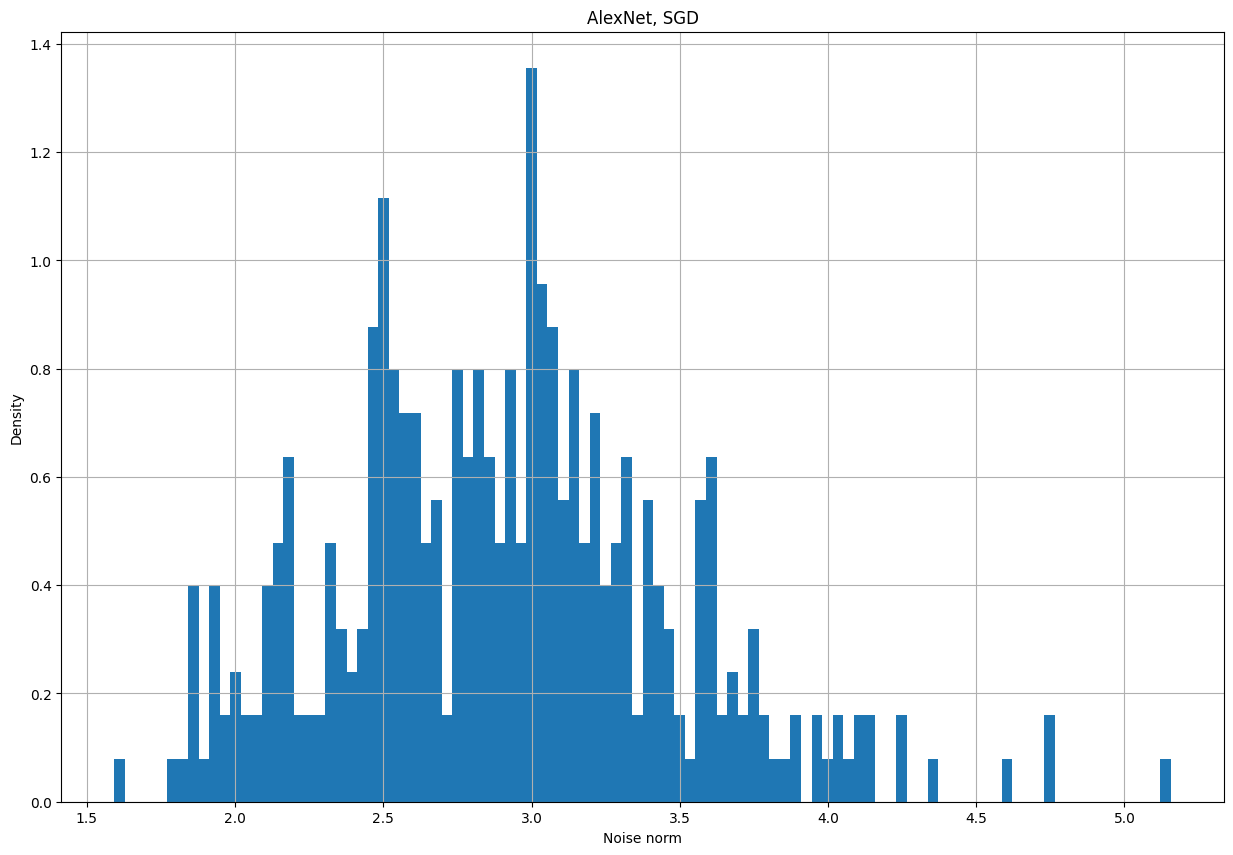

In [34]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_sgd, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('AlexNet, SGD')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

In [35]:
model = AlexNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(model.parameters(), lr=1e-3)
cb_adam = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_adam, n_epochs=15, callback=cb_adam)
loss_adam, acc_adam = evaluate(model, test_loader, loss_fn)
print(f'AlexNet, test loss, Adam: {loss_adam}')
print(f'AlexNet, test accuracy, Adam: {acc_adam}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

AlexNet, test loss, Adam: 1.2560789585113525
AlexNet, test accuracy, Adam: 0.6985


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

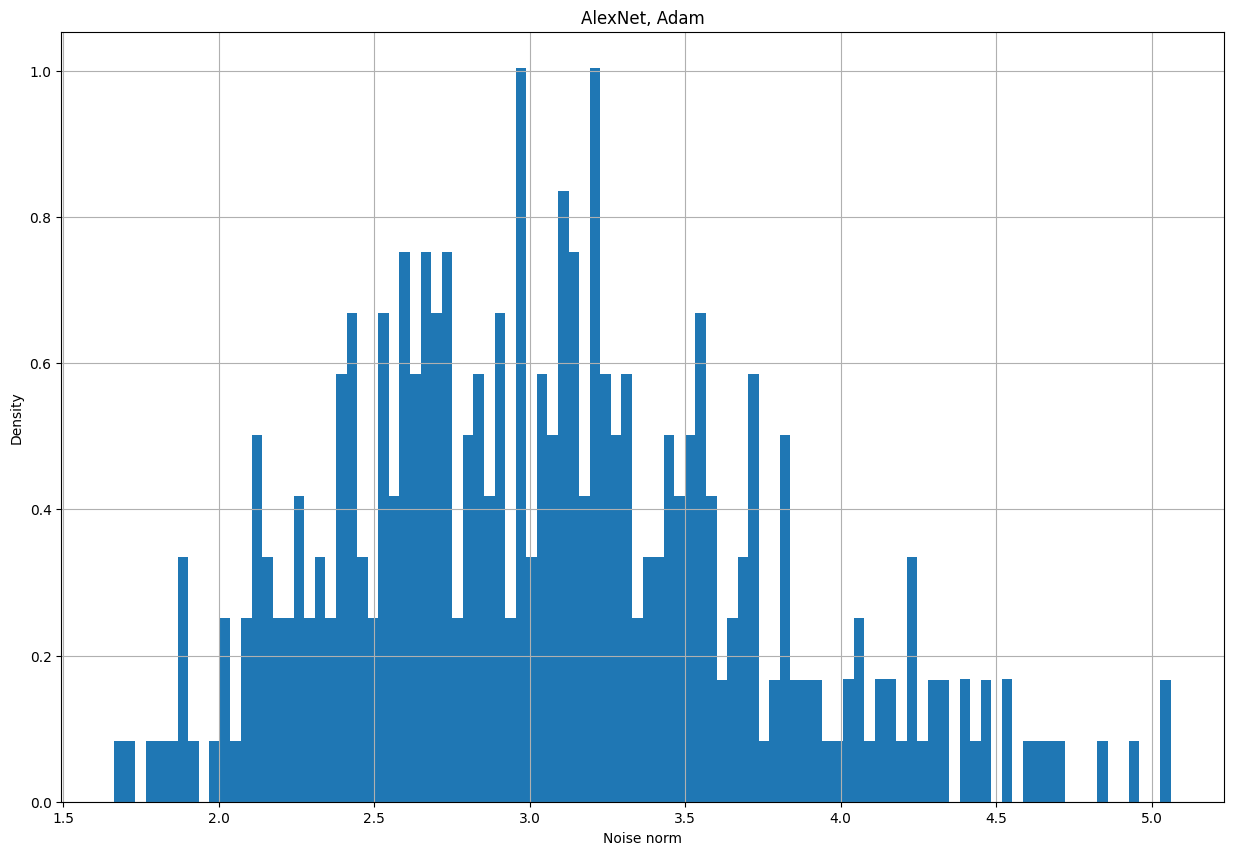

In [36]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_adam, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('AlexNet, Adam')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

In [38]:
model = AlexNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_clip_sstm = clipped_SSTM(model.parameters(), lr=1e-2, L=10, clipping_type='norm', a_k_ratio_upper_bound=0.99)
cb_clip_sstm = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_clip_sstm, n_epochs=15, callback=cb_clip_sstm)
loss_clip_sstm, acc_clip_sstm = evaluate(model, test_loader, loss_fn)
print(f'AlexNet, test loss, Clip SSTM: {loss_clip_sstm}')
print(f'AlexNet, test accuracy, Clip SSTM: {acc_clip_sstm}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

AlexNet, test loss, Clip SSTM: 1.0582150220870972
AlexNet, test accuracy, Clip SSTM: 0.7459


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

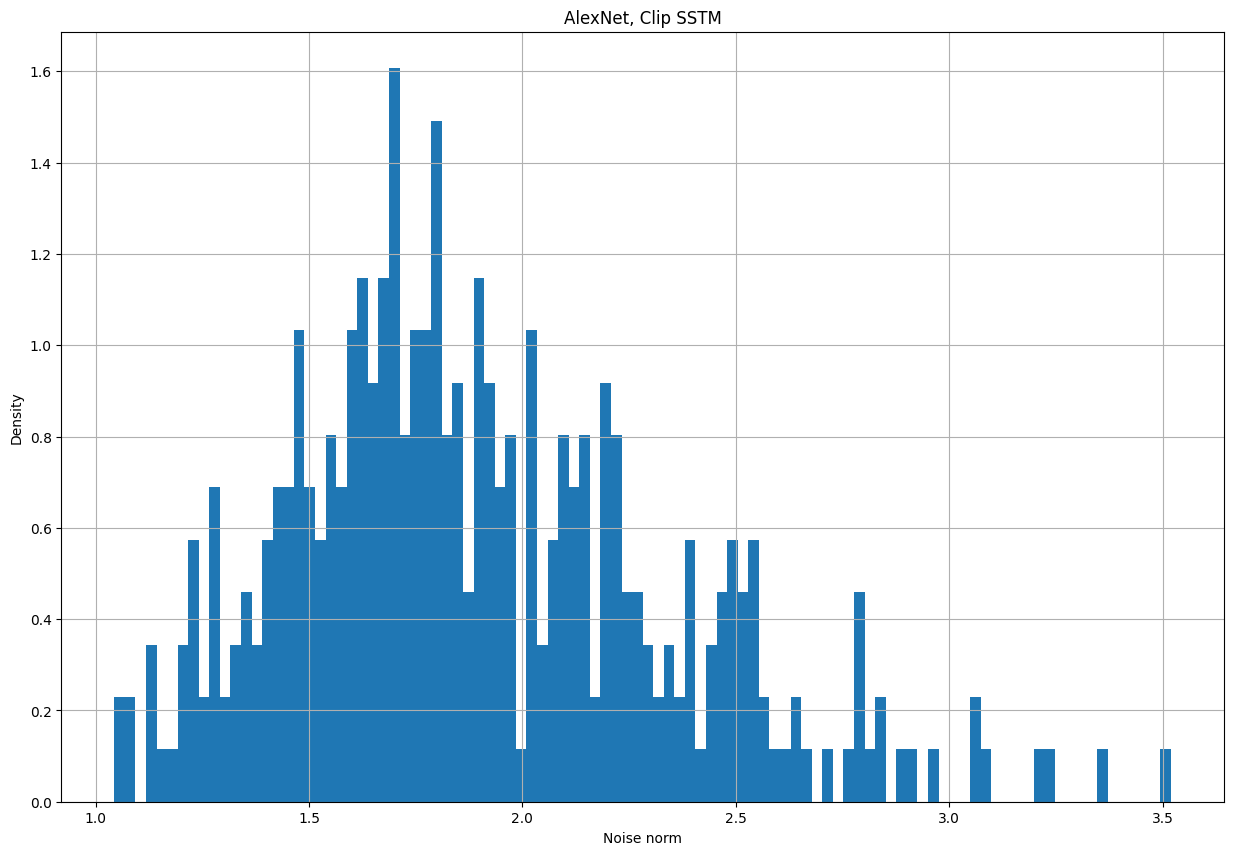

In [39]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_clip_sstm, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('AlexNet, Clip SSTM')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

In [40]:
model = AlexNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_clip_sgd = clipped_SGD(model.parameters(), lr=5e-2, momentum=0.9, clipping_type="coordinate_wise", clipping_level=0.1)
cb_clip_sgd = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_clip_sgd, n_epochs=15, callback=cb_clip_sgd)
loss_clip_sgd, acc_clip_sgd = evaluate(model, test_loader, loss_fn)
print(f'AlexNet, test loss, Clip SGD: {loss_clip_sgd}')
print(f'AlexNet, test accuracy, Clip SGD: {acc_clip_sgd}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

AlexNet, test loss, Clip SGD: 1.109334111213684
AlexNet, test accuracy, Clip SGD: 0.7272


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

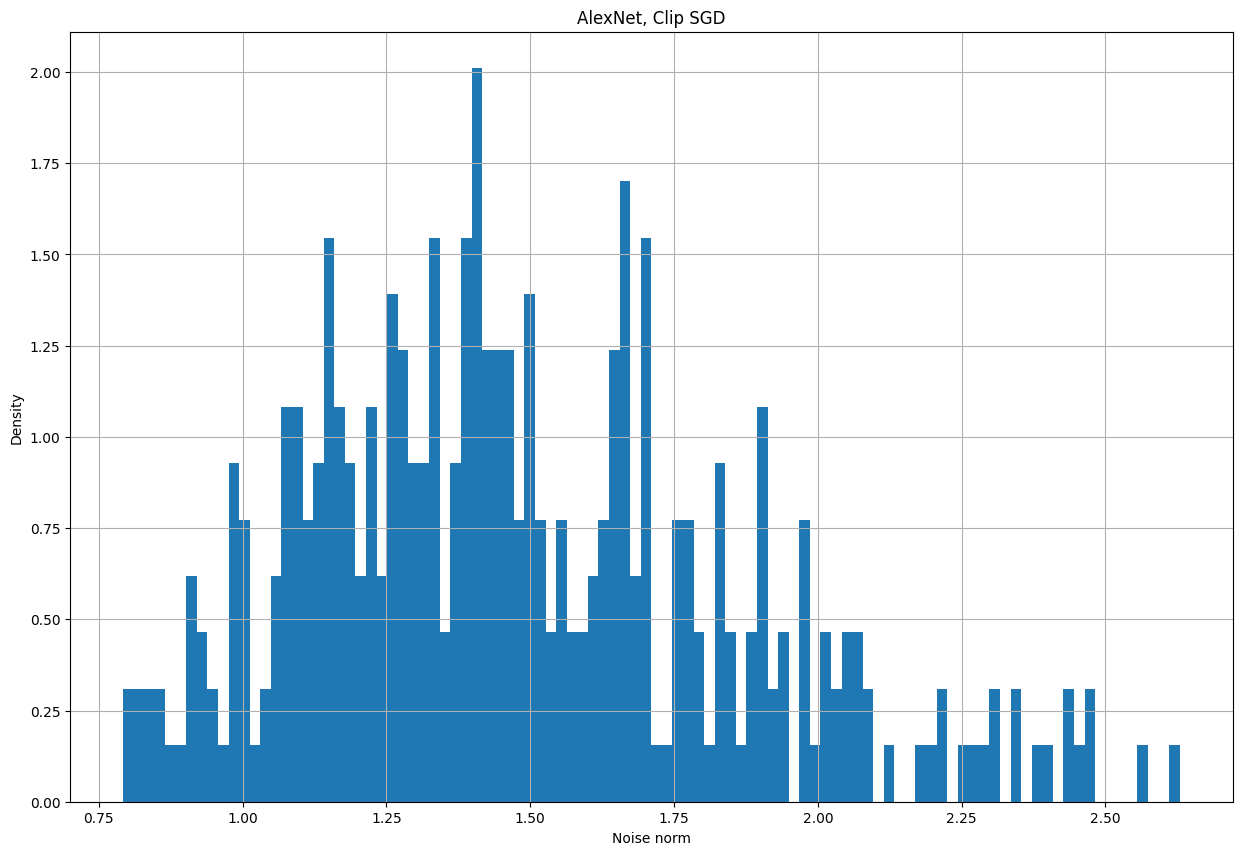

In [41]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_clip_sgd, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('AlexNet, Clip SGD')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

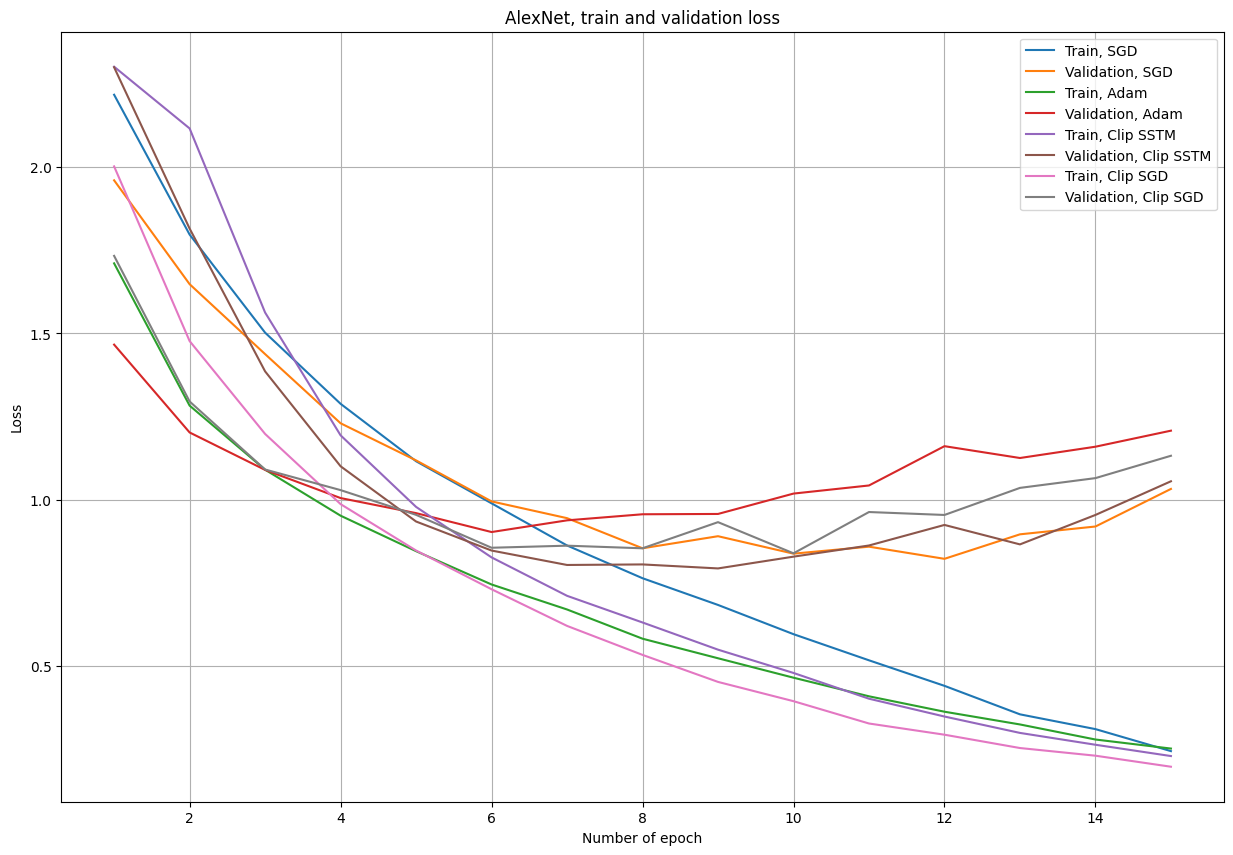

In [42]:
plt.figure(figsize=(15, 10))
plt.title('AlexNet, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(15) + 1
plt.plot(epochs, cb_sgd.train_losses, label='Train, SGD')
plt.plot(epochs, cb_sgd.val_losses, label='Validation, SGD')
plt.plot(epochs, cb_adam.train_losses, label='Train, Adam')
plt.plot(epochs, cb_adam.val_losses, label='Validation, Adam')
plt.plot(epochs, cb_clip_sstm.train_losses, label='Train, Clip SSTM')
plt.plot(epochs, cb_clip_sstm.val_losses, label='Validation, Clip SSTM')
plt.plot(epochs, cb_clip_sgd.train_losses, label='Train, Clip SGD')
plt.plot(epochs, cb_clip_sgd.val_losses, label='Validation, Clip SGD')
plt.legend()
plt.grid(True)

In [43]:
print(f'Best loss on train, SGD: {np.min(cb_sgd.train_losses)}, on {np.argmin(cb_sgd.train_losses) + 1} epoch')
print(f'Best loss on validation, SGD: {np.min(cb_sgd.val_losses)}, on {np.argmin(cb_sgd.val_losses) + 1} epoch')
print(f'Best loss on train, Adam: {np.min(cb_adam.train_losses)}, on {np.argmin(cb_adam.train_losses) + 1} epoch')
print(f'Best loss on validation, Adam: {np.min(cb_adam.val_losses)}, on {np.argmin(cb_adam.val_losses) + 1} epoch')
print(f'Best loss on train, Clip SSTM: {np.min(cb_clip_sstm.train_losses)}, on {np.argmin(cb_clip_sstm.train_losses) + 1} epoch')
print(f'Best loss on validation, Clip SSTM: {np.min(cb_clip_sstm.val_losses)}, on {np.argmin(cb_clip_sstm.val_losses) + 1} epoch')
print(f'Best loss on train, Clip SGD: {np.min(cb_clip_sgd.train_losses)}, on {np.argmin(cb_clip_sgd.train_losses) + 1} epoch')
print(f'Best loss on validation, Clip SGD: {np.min(cb_clip_sgd.val_losses)}, on {np.argmin(cb_clip_sgd.val_losses) + 1} epoch')

Best loss on train, SGD: 0.24382807719442579, on 15 epoch
Best loss on validation, SGD: 0.8221803903579712, on 12 epoch
Best loss on train, Adam: 0.25153718948364256, on 15 epoch
Best loss on validation, Adam: 0.9027227759361267, on 6 epoch
Best loss on train, Clip SSTM: 0.22901720115807322, on 15 epoch
Best loss on validation, Clip SSTM: 0.7932943105697632, on 9 epoch
Best loss on train, Clip SGD: 0.196921299261517, on 15 epoch
Best loss on validation, Clip SGD: 0.8387374877929688, on 10 epoch


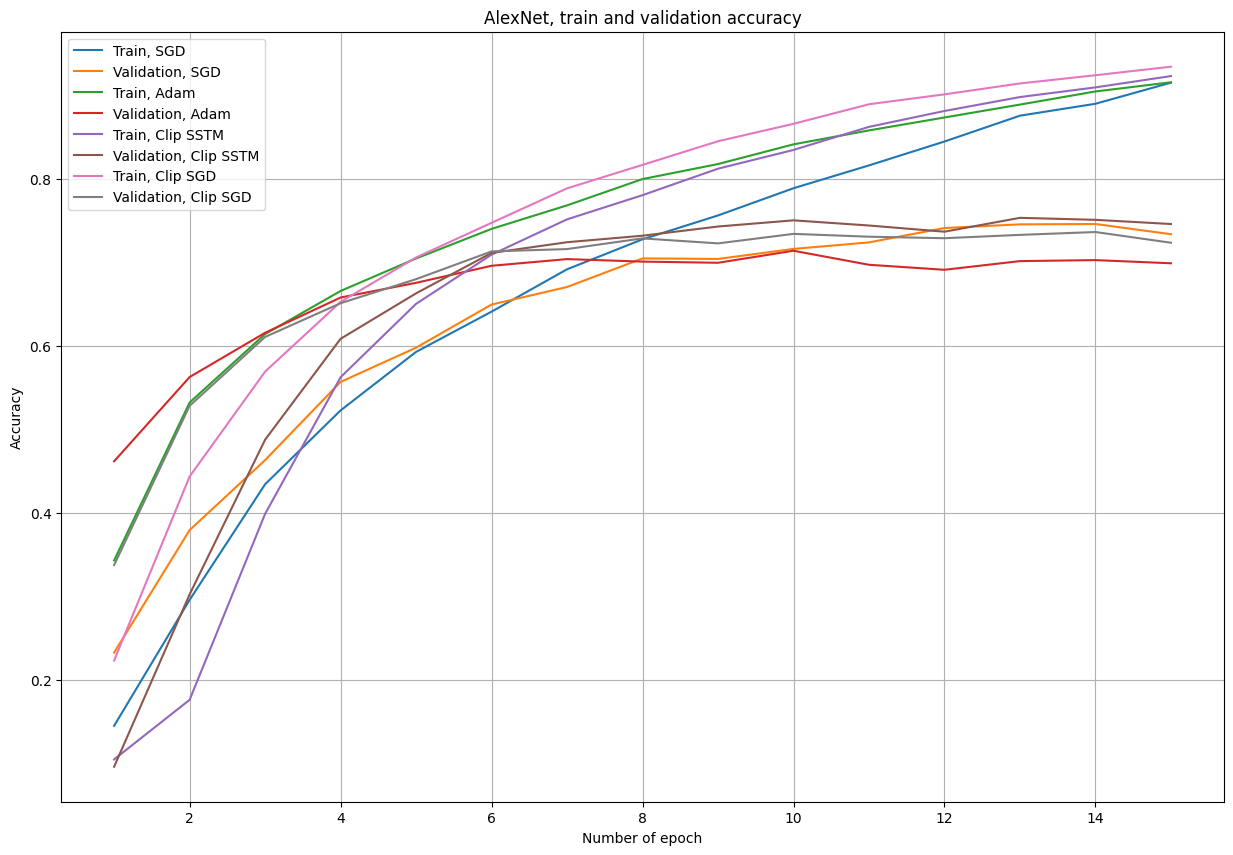

In [44]:
plt.figure(figsize=(15, 10))
plt.title('AlexNet, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(15) + 1
plt.plot(epochs, cb_sgd.train_accs, label='Train, SGD')
plt.plot(epochs, cb_sgd.val_accs, label='Validation, SGD')
plt.plot(epochs, cb_adam.train_accs, label='Train, Adam')
plt.plot(epochs, cb_adam.val_accs, label='Validation, Adam')
plt.plot(epochs, cb_clip_sstm.train_accs, label='Train, Clip SSTM')
plt.plot(epochs, cb_clip_sstm.val_accs, label='Validation, Clip SSTM')
plt.plot(epochs, cb_clip_sgd.train_accs, label='Train, Clip SGD')
plt.plot(epochs, cb_clip_sgd.val_accs, label='Validation, Clip SGD')

plt.legend()
plt.grid(True)

In [45]:
print(f'Best accuracy on train, SGD: {np.max(cb_sgd.train_accs)}, on {np.argmax(cb_sgd.train_accs) + 1} epoch')
print(f'Best accuracy on validation, SGD: {np.max(cb_sgd.val_accs)}, on {np.argmax(cb_sgd.val_accs) + 1} epoch')
print(f'Best accuracy on train, Adam: {np.max(cb_adam.train_accs)}, on {np.argmax(cb_adam.train_accs) + 1} epoch')
print(f'Best accuracy on validation, Adam: {np.max(cb_adam.val_accs)}, on {np.argmax(cb_adam.val_accs) + 1} epoch')
print(f'Best accuracy on train, Clip SSTM: {np.max(cb_clip_sstm.train_accs)}, on {np.argmax(cb_clip_sstm.train_accs) + 1} epoch')
print(f'Best accuracy on validation, Clip SSTM: {np.max(cb_clip_sstm.val_accs)}, on {np.argmax(cb_clip_sstm.val_accs) + 1} epoch')
print(f'Best accuracy on train, Clip SGD: {np.max(cb_clip_sgd.train_accs)}, on {np.argmax(cb_clip_sgd.train_accs) + 1} epoch')
print(f'Best accuracy on validation, Clip SGD: {np.max(cb_clip_sgd.val_accs)}, on {np.argmax(cb_clip_sgd.val_accs) + 1} epoch')

Best accuracy on train, SGD: 0.9149777777777778, on 15 epoch
Best accuracy on validation, SGD: 0.7458, on 14 epoch
Best accuracy on train, Adam: 0.9154222222222222, on 15 epoch
Best accuracy on validation, Adam: 0.7138, on 10 epoch
Best accuracy on train, Clip SSTM: 0.9228666666666666, on 15 epoch
Best accuracy on validation, Clip SSTM: 0.7532, on 13 epoch
Best accuracy on train, Clip SGD: 0.9340666666666667, on 15 epoch
Best accuracy on validation, Clip SGD: 0.7362, on 14 epoch


# VGG


In [47]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)


    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def VGG11():
    return VGG('VGG11')


def VGG13():
    return VGG('VGG13')


def VGG16():
    return VGG('VGG16')


def VGG19():
    return VGG('VGG19')

**VGG19**

In [48]:
model = VGG19()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
cb_sgd = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_sgd, n_epochs=15, callback=cb_sgd)
loss_sgd, acc_sgd = evaluate(model, test_loader, loss_fn)
print(f'VGG19, test loss, SGD: {loss_sgd}')
print(f'VGG19, test accuracy, SGD: {acc_sgd}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

VGG19, test loss, SGD: 0.854780375957489
VGG19, test accuracy, SGD: 0.8154


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

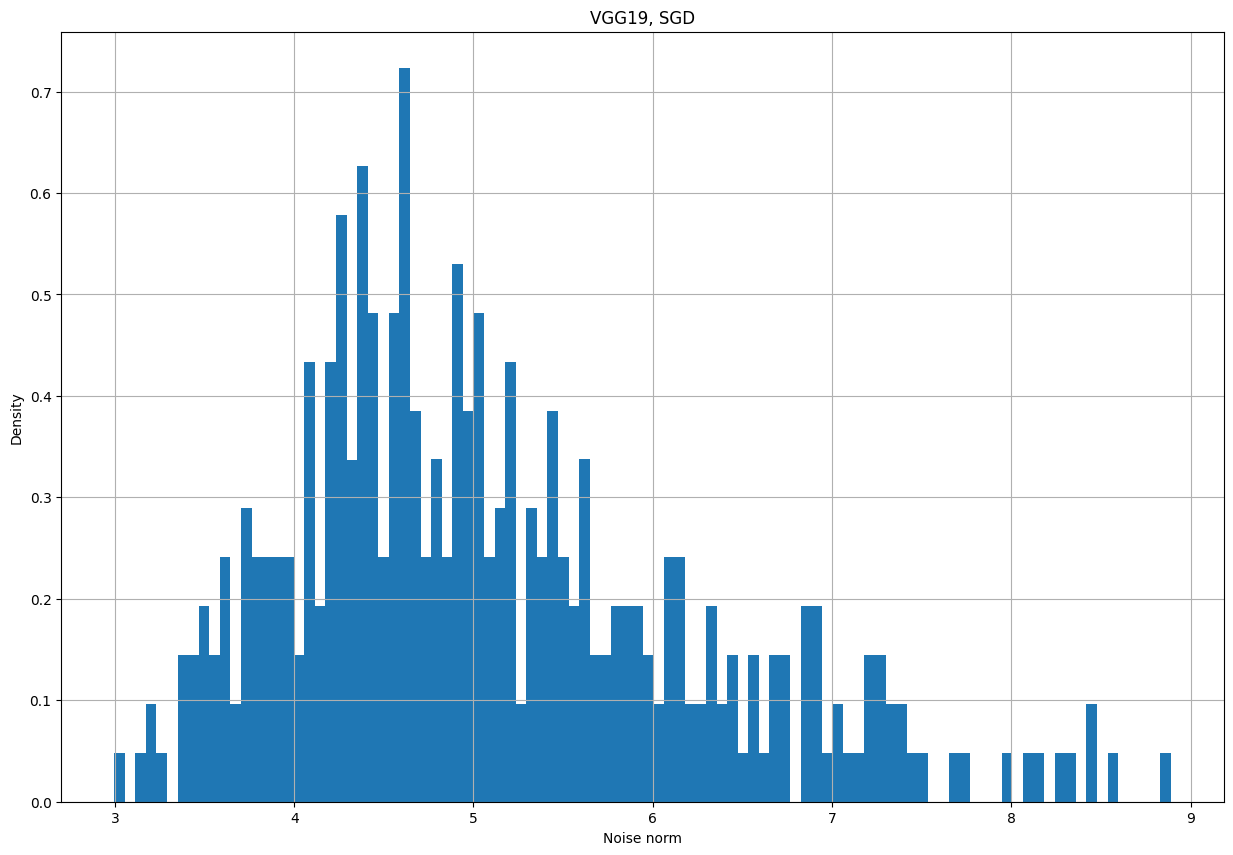

In [49]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_sgd, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('VGG19, SGD')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

In [50]:
model = VGG19()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(model.parameters(), lr=1e-3)
cb_adam = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_adam, n_epochs=15, callback=cb_adam)
loss_adam, acc_adam = evaluate(model, test_loader, loss_fn)
print(f'VGG19, test loss, Adam: {loss_adam}')
print(f'VGG19, test accuracy, Adam: {acc_adam}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

VGG19, test loss, Adam: 0.7319303154945374
VGG19, test accuracy, Adam: 0.8187


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

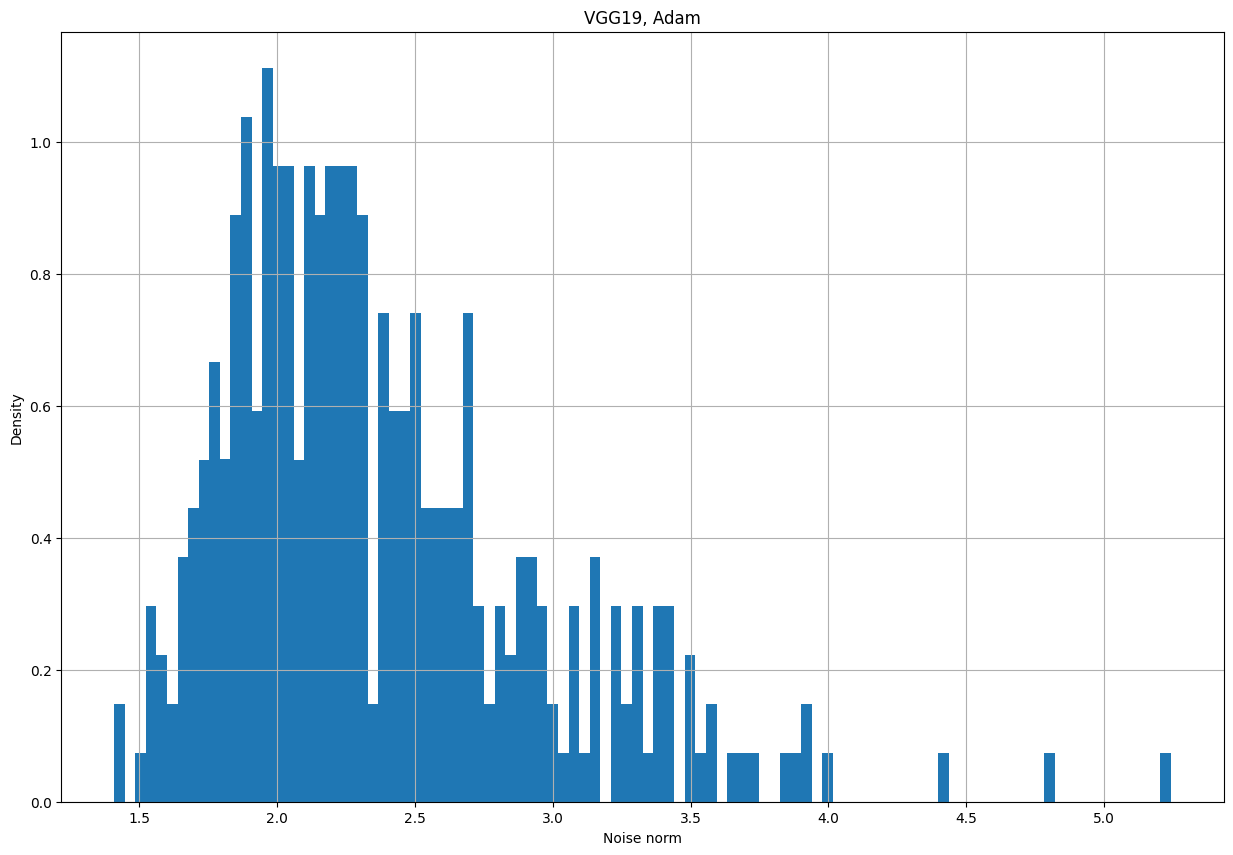

In [51]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_adam, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('VGG19, Adam')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

In [52]:
model = VGG19()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_clip_sstm = clipped_SSTM(model.parameters(), lr=1e-2, L=10, clipping_type='norm', a_k_ratio_upper_bound=0.99)
cb_clip_sstm = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_clip_sstm, n_epochs=15, callback=cb_clip_sstm)
loss_clip_sstm, acc_clip_sstm = evaluate(model, test_loader, loss_fn)
print(f'VGG19, test loss, Clip SSTM: {loss_clip_sstm}')
print(f'VGG19, test accuracy, Clip SSTM: {acc_clip_sstm}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

VGG19, test loss, Clip SSTM: 0.6720604300498962
VGG19, test accuracy, Clip SSTM: 0.8441


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

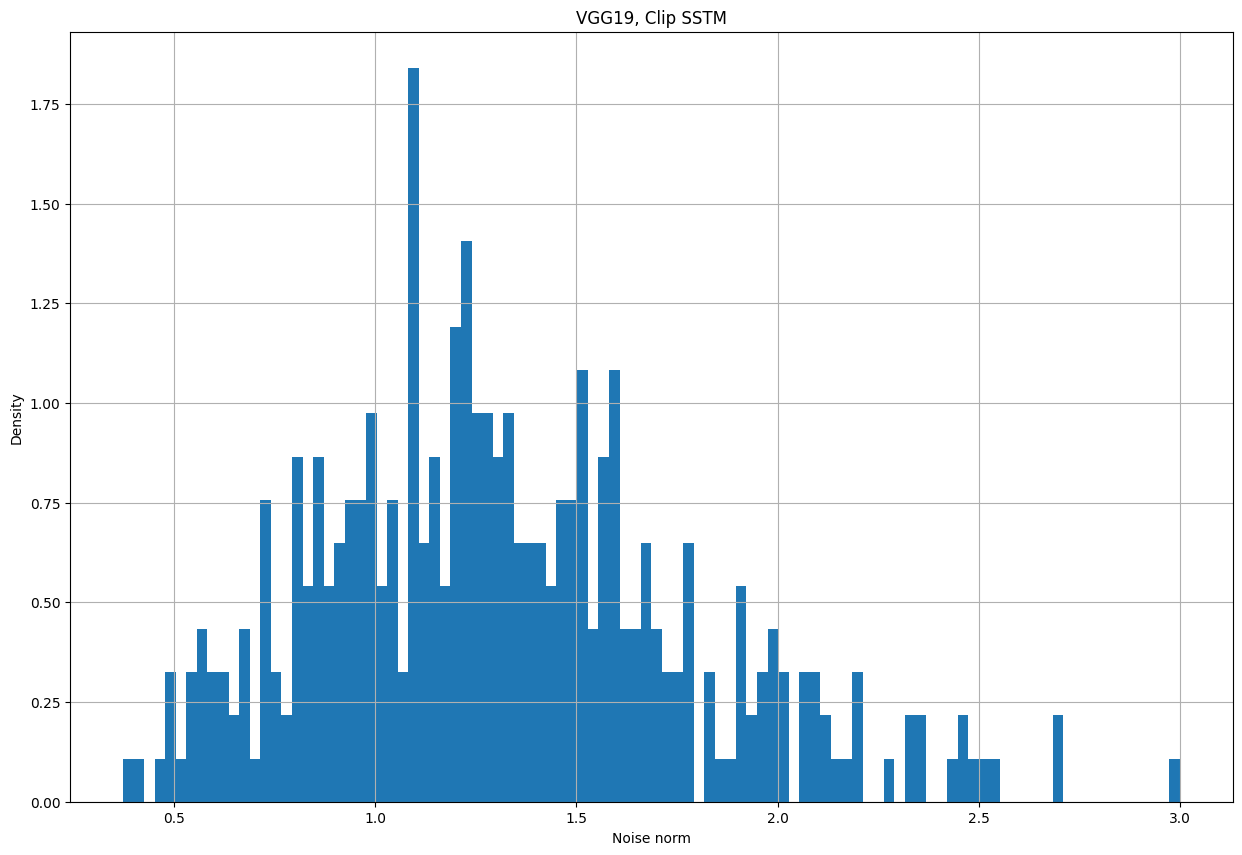

In [53]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_clip_sstm, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('VGG19, Clip SSTM')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

In [54]:
model = VGG19()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_clip_sgd = clipped_SGD(model.parameters(), lr=5e-2, momentum=0.9, clipping_type="coordinate_wise", clipping_level=0.1)
cb_clip_sgd = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_clip_sgd, n_epochs=15, callback=cb_clip_sgd)
loss_clip_sgd, acc_clip_sgd = evaluate(model, test_loader, loss_fn)
print(f'VGG19, test loss, Clip SGD: {loss_clip_sgd}')
print(f'VGG19, test accuracy, Clip SGD: {acc_clip_sgd}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

VGG19, test loss, Clip SGD: 0.6437540054321289
VGG19, test accuracy, Clip SGD: 0.8019


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

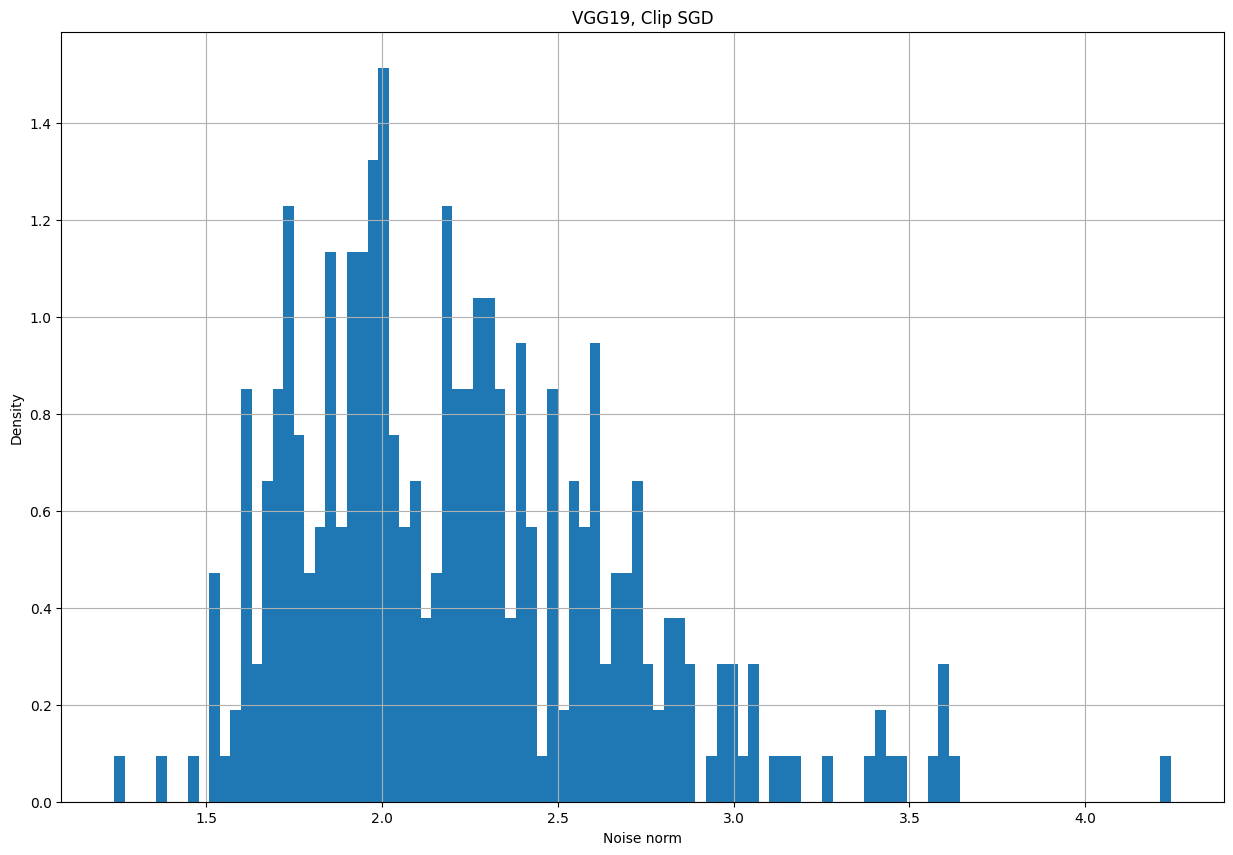

In [55]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_clip_sgd, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('VGG19, Clip SGD')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

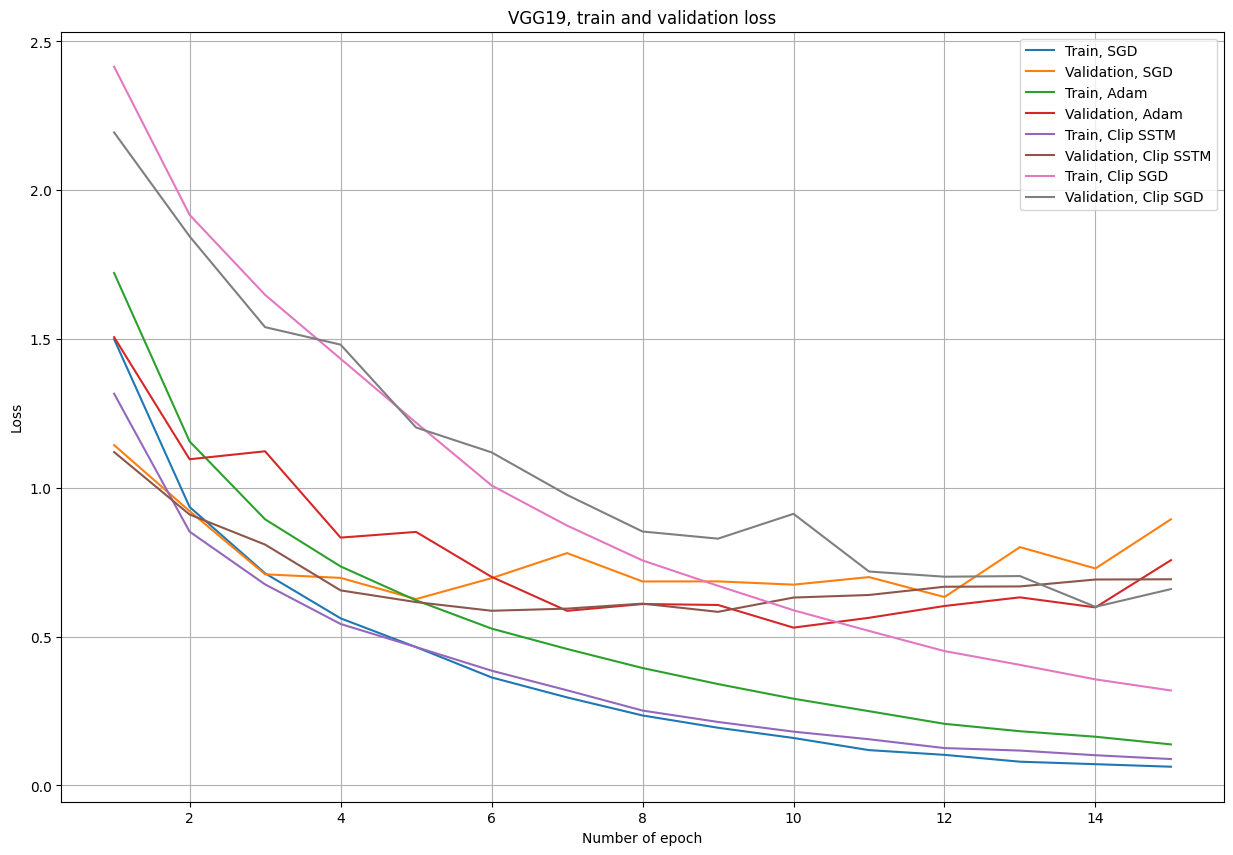

In [56]:
plt.figure(figsize=(15, 10))
plt.title('VGG19, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(15) + 1
plt.plot(epochs, cb_sgd.train_losses, label='Train, SGD')
plt.plot(epochs, cb_sgd.val_losses, label='Validation, SGD')
plt.plot(epochs, cb_adam.train_losses, label='Train, Adam')
plt.plot(epochs, cb_adam.val_losses, label='Validation, Adam')
plt.plot(epochs, cb_clip_sstm.train_losses, label='Train, Clip SSTM')
plt.plot(epochs, cb_clip_sstm.val_losses, label='Validation, Clip SSTM')
plt.plot(epochs, cb_clip_sgd.train_losses, label='Train, Clip SGD')
plt.plot(epochs, cb_clip_sgd.val_losses, label='Validation, Clip SGD')
plt.legend()
plt.grid(True)

In [57]:
print(f'Best loss on train, SGD: {np.min(cb_sgd.train_losses)}, on {np.argmin(cb_sgd.train_losses) + 1} epoch')
print(f'Best loss on validation, SGD: {np.min(cb_sgd.val_losses)}, on {np.argmin(cb_sgd.val_losses) + 1} epoch')
print(f'Best loss on train, Adam: {np.min(cb_adam.train_losses)}, on {np.argmin(cb_adam.train_losses) + 1} epoch')
print(f'Best loss on validation, Adam: {np.min(cb_adam.val_losses)}, on {np.argmin(cb_adam.val_losses) + 1} epoch')
print(f'Best loss on train, Clip SSTM: {np.min(cb_clip_sstm.train_losses)}, on {np.argmin(cb_clip_sstm.train_losses) + 1} epoch')
print(f'Best loss on validation, Clip SSTM: {np.min(cb_clip_sstm.val_losses)}, on {np.argmin(cb_clip_sstm.val_losses) + 1} epoch')
print(f'Best loss on train, Clip SGD: {np.min(cb_clip_sgd.train_losses)}, on {np.argmin(cb_clip_sgd.train_losses) + 1} epoch')
print(f'Best loss on validation, Clip SGD: {np.min(cb_clip_sgd.val_losses)}, on {np.argmin(cb_clip_sgd.val_losses) + 1} epoch')

Best loss on train, SGD: 0.0627729972600937, on 15 epoch
Best loss on validation, SGD: 0.6261414885520935, on 5 epoch
Best loss on train, Adam: 0.13779908970726862, on 15 epoch
Best loss on validation, Adam: 0.5301418304443359, on 10 epoch
Best loss on train, Clip SSTM: 0.08854872634013494, on 15 epoch
Best loss on validation, Clip SSTM: 0.5832456350326538, on 9 epoch
Best loss on train, Clip SGD: 0.3189598926438226, on 15 epoch
Best loss on validation, Clip SGD: 0.6000610589981079, on 14 epoch


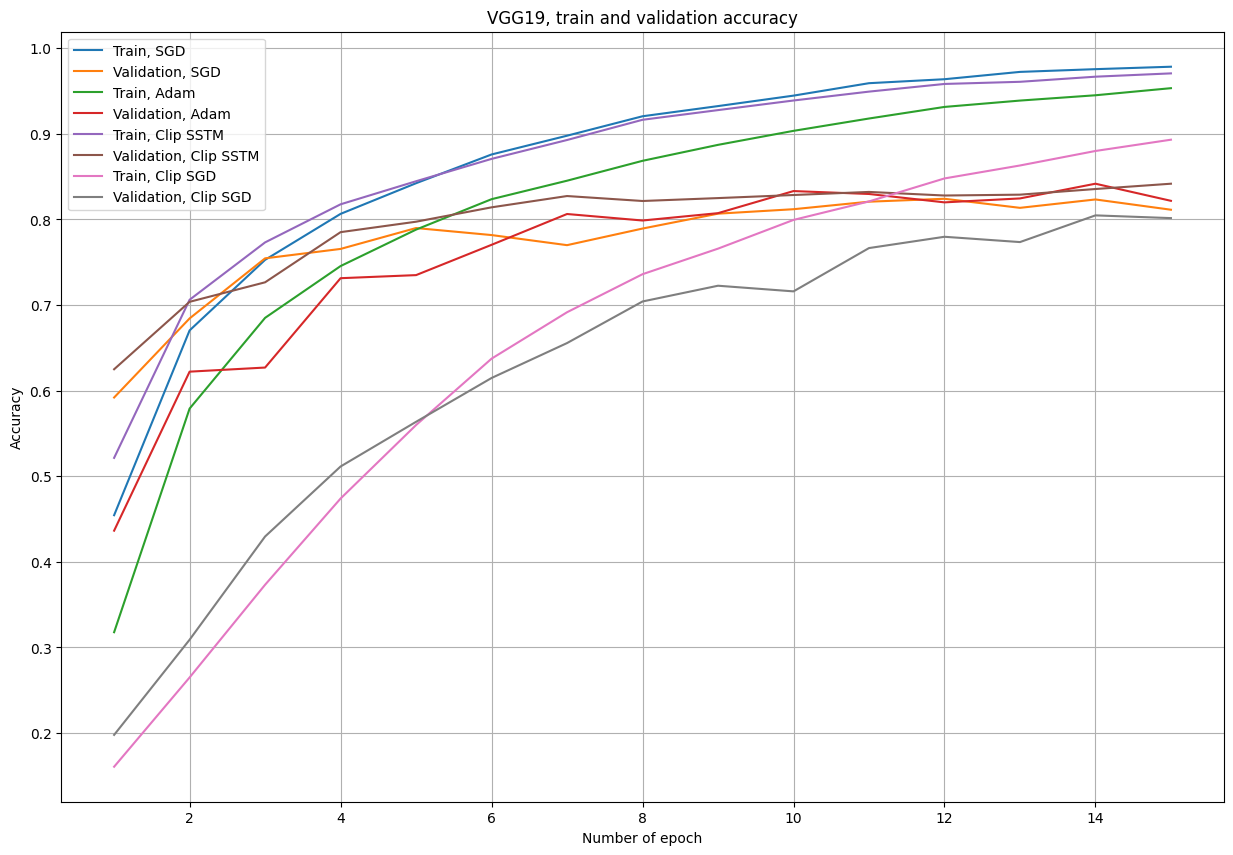

In [58]:
plt.figure(figsize=(15, 10))
plt.title('VGG19, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(15) + 1
plt.plot(epochs, cb_sgd.train_accs, label='Train, SGD')
plt.plot(epochs, cb_sgd.val_accs, label='Validation, SGD')
plt.plot(epochs, cb_adam.train_accs, label='Train, Adam')
plt.plot(epochs, cb_adam.val_accs, label='Validation, Adam')
plt.plot(epochs, cb_clip_sstm.train_accs, label='Train, Clip SSTM')
plt.plot(epochs, cb_clip_sstm.val_accs, label='Validation, Clip SSTM')
plt.plot(epochs, cb_clip_sgd.train_accs, label='Train, Clip SGD')
plt.plot(epochs, cb_clip_sgd.val_accs, label='Validation, Clip SGD')

plt.legend()
plt.grid(True)

In [59]:
print(f'Best accuracy on train, SGD: {np.max(cb_sgd.train_accs)}, on {np.argmax(cb_sgd.train_accs) + 1} epoch')
print(f'Best accuracy on validation, SGD: {np.max(cb_sgd.val_accs)}, on {np.argmax(cb_sgd.val_accs) + 1} epoch')
print(f'Best accuracy on train, Adam: {np.max(cb_adam.train_accs)}, on {np.argmax(cb_adam.train_accs) + 1} epoch')
print(f'Best accuracy on validation, Adam: {np.max(cb_adam.val_accs)}, on {np.argmax(cb_adam.val_accs) + 1} epoch')
print(f'Best accuracy on train, Clip SSTM: {np.max(cb_clip_sstm.train_accs)}, on {np.argmax(cb_clip_sstm.train_accs) + 1} epoch')
print(f'Best accuracy on validation, Clip SSTM: {np.max(cb_clip_sstm.val_accs)}, on {np.argmax(cb_clip_sstm.val_accs) + 1} epoch')
print(f'Best accuracy on train, Clip SGD: {np.max(cb_clip_sgd.train_accs)}, on {np.argmax(cb_clip_sgd.train_accs) + 1} epoch')
print(f'Best accuracy on validation, Clip SGD: {np.max(cb_clip_sgd.val_accs)}, on {np.argmax(cb_clip_sgd.val_accs) + 1} epoch')

Best accuracy on train, SGD: 0.9784888888888889, on 15 epoch
Best accuracy on validation, SGD: 0.8242, on 12 epoch
Best accuracy on train, Adam: 0.9534222222222222, on 15 epoch
Best accuracy on validation, Adam: 0.8418, on 14 epoch
Best accuracy on train, Clip SSTM: 0.9707111111111111, on 15 epoch
Best accuracy on validation, Clip SSTM: 0.8418, on 15 epoch
Best accuracy on train, Clip SGD: 0.8932222222222223, on 15 epoch
Best accuracy on validation, Clip SGD: 0.8048, on 14 epoch


# ResNet

In [61]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])

**ResNet18**

In [62]:
model = ResNet18()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
cb_sgd = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_sgd, n_epochs=15, callback=cb_sgd)
loss_sgd, acc_sgd = evaluate(model, test_loader, loss_fn)
print(f'ResNet18, test loss, SGD: {loss_sgd}')
print(f'ResNet18, test accuracy, SGD: {acc_sgd}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

ResNet18, test loss, SGD: 0.8089136481285095
ResNet18, test accuracy, SGD: 0.8395


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

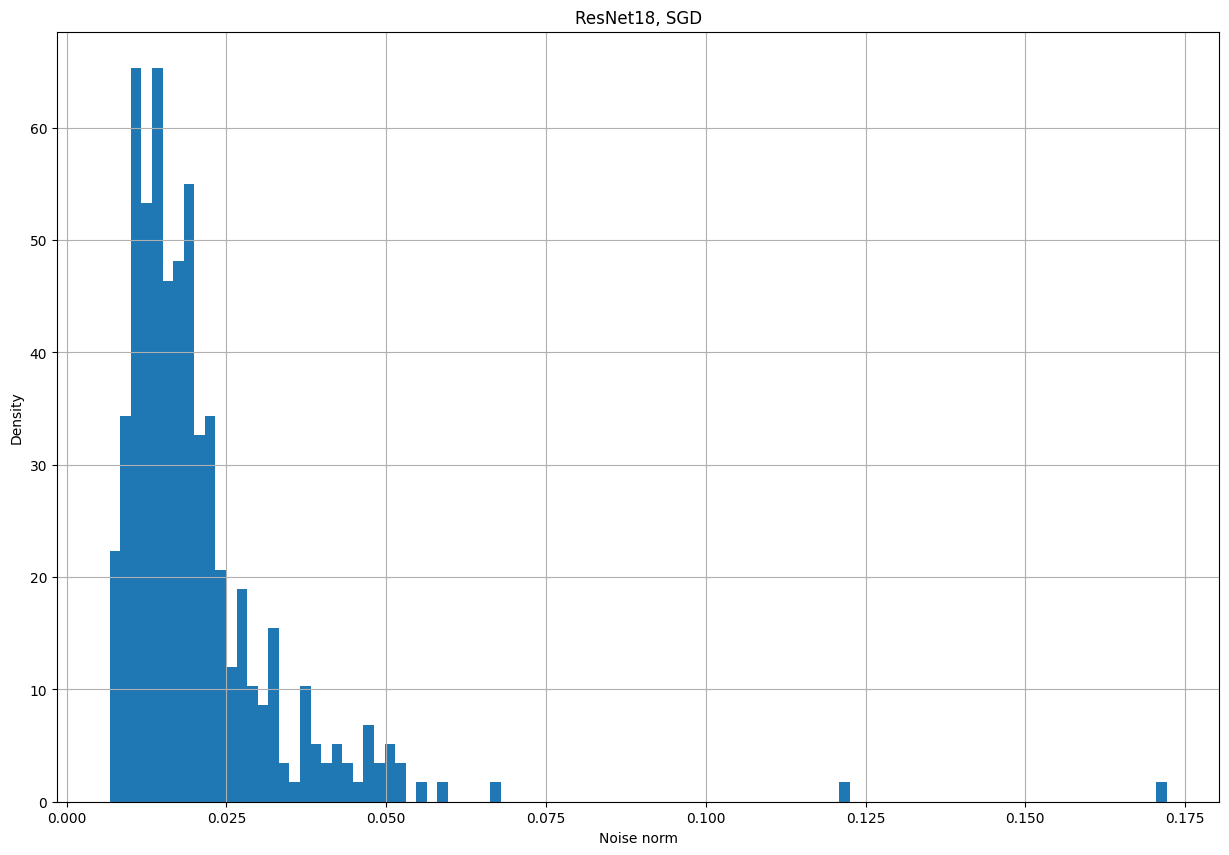

In [63]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_sgd, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('ResNet18, SGD')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

In [64]:
model = ResNet18()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(model.parameters(), lr=1e-3)
cb_adam = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_adam, n_epochs=15, callback=cb_adam)
loss_adam, acc_adam = evaluate(model, test_loader, loss_fn)
print(f'ResNet18, test loss, Adam: {loss_adam}')
print(f'ResNet18, test accuracy, Adam: {acc_adam}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

ResNet18, test loss, Adam: 0.9334450364112854
ResNet18, test accuracy, Adam: 0.8141


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

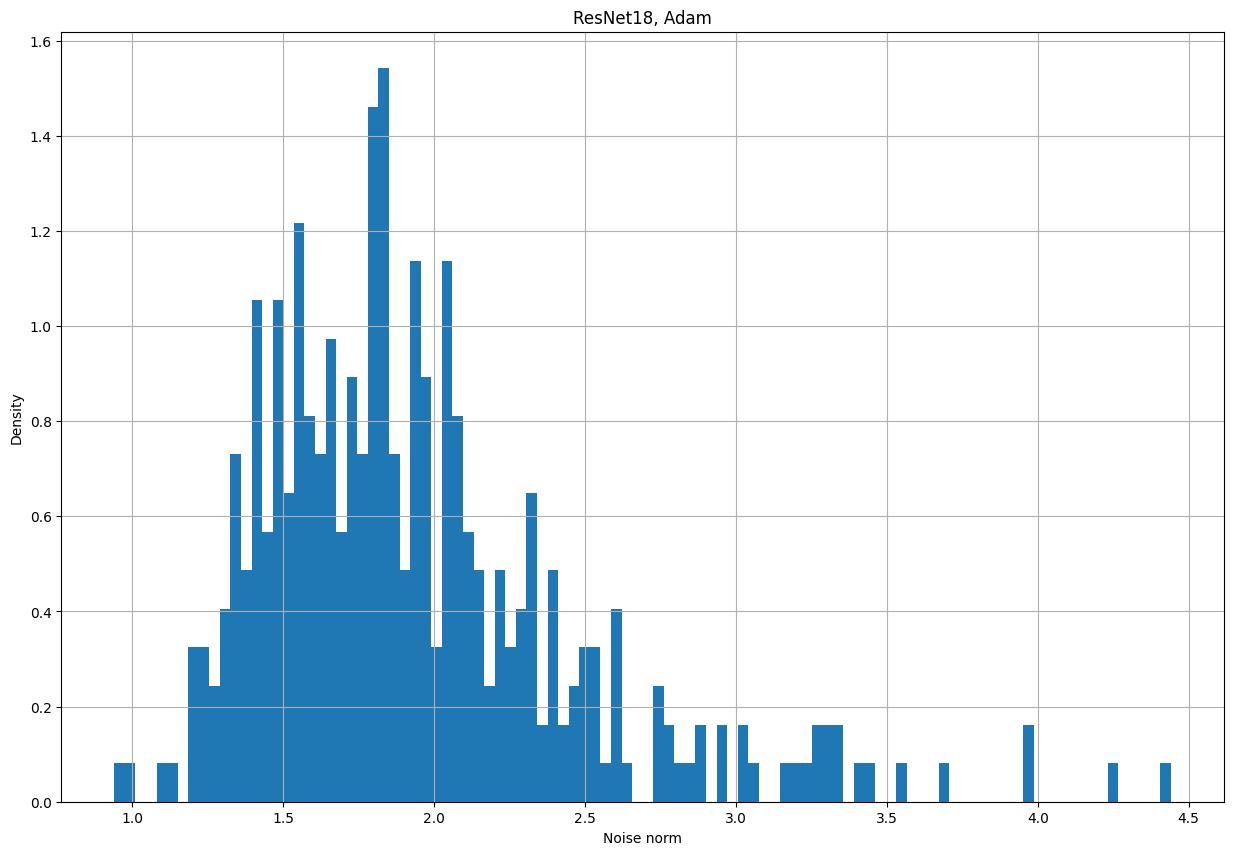

In [65]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_adam, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('ResNet18, Adam')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

In [66]:
model = ResNet18()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_clip_sstm = clipped_SSTM(model.parameters(), lr=1e-2, L=10, clipping_type='norm', a_k_ratio_upper_bound=0.99)
cb_clip_sstm = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_clip_sstm, n_epochs=15, callback=cb_clip_sstm)
loss_clip_sstm, acc_clip_sstm = evaluate(model, test_loader, loss_fn)
print(f'ResNet18, test loss, Clip SSTM: {loss_clip_sstm}')
print(f'ResNet18, test accuracy, Clip SSTM: {acc_clip_sstm}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

ResNet18, test loss, Clip SSTM: 0.8930917978286743
ResNet18, test accuracy, Clip SSTM: 0.8238


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

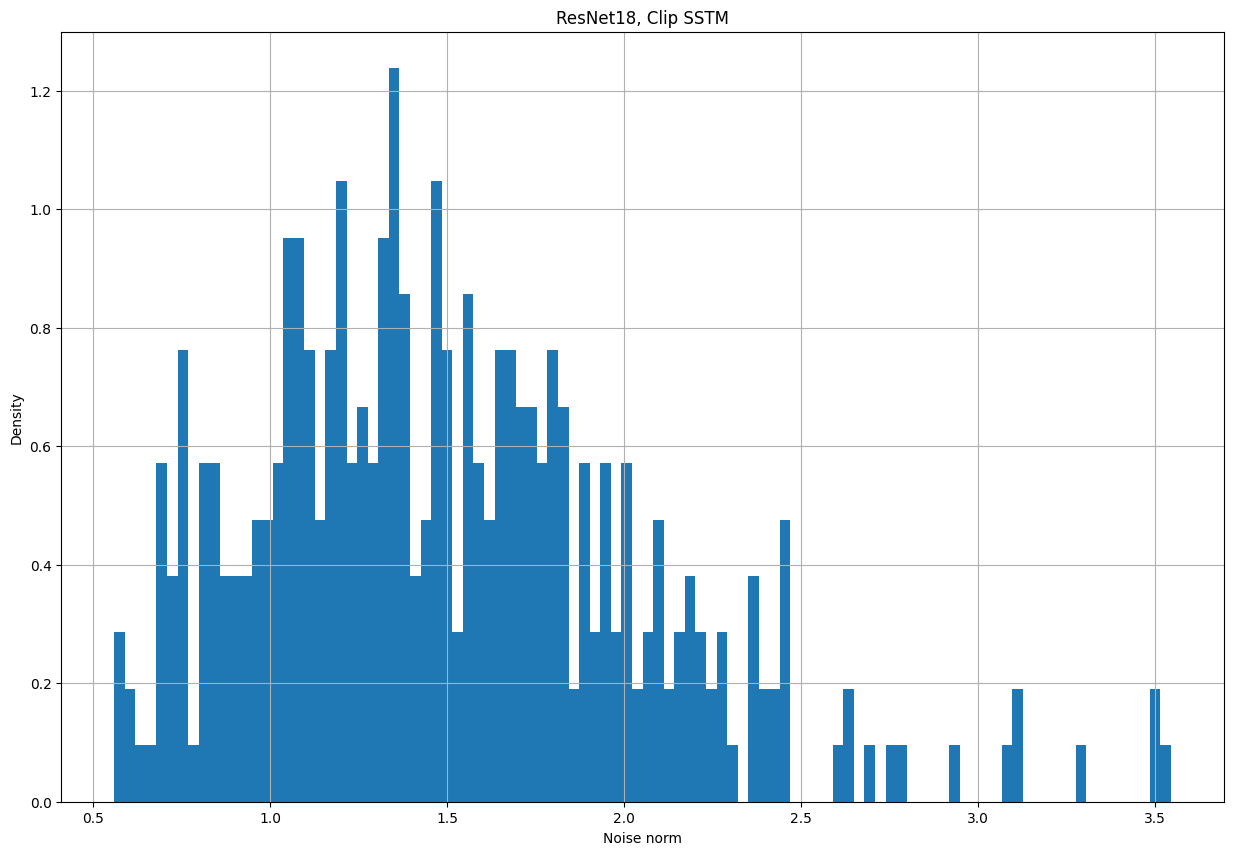

In [67]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_clip_sstm, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('ResNet18, Clip SSTM')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)


In [68]:
model = ResNet18()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_clip_sgd = clipped_SGD(model.parameters(), lr=5e-2, momentum=0.9, clipping_type="coordinate_wise", clipping_level=0.1)
cb_clip_sgd = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_clip_sgd, n_epochs=15, callback=cb_clip_sgd)
loss_clip_sgd, acc_clip_sgd = evaluate(model, test_loader, loss_fn)
print(f'ResNet18, test loss, Clip SGD: {loss_clip_sgd}')
print(f'ResNet18, test accuracy, Clip SGD: {acc_clip_sgd}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

ResNet18, test loss, Clip SGD: 0.9943392872810364
ResNet18, test accuracy, Clip SGD: 0.8212


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

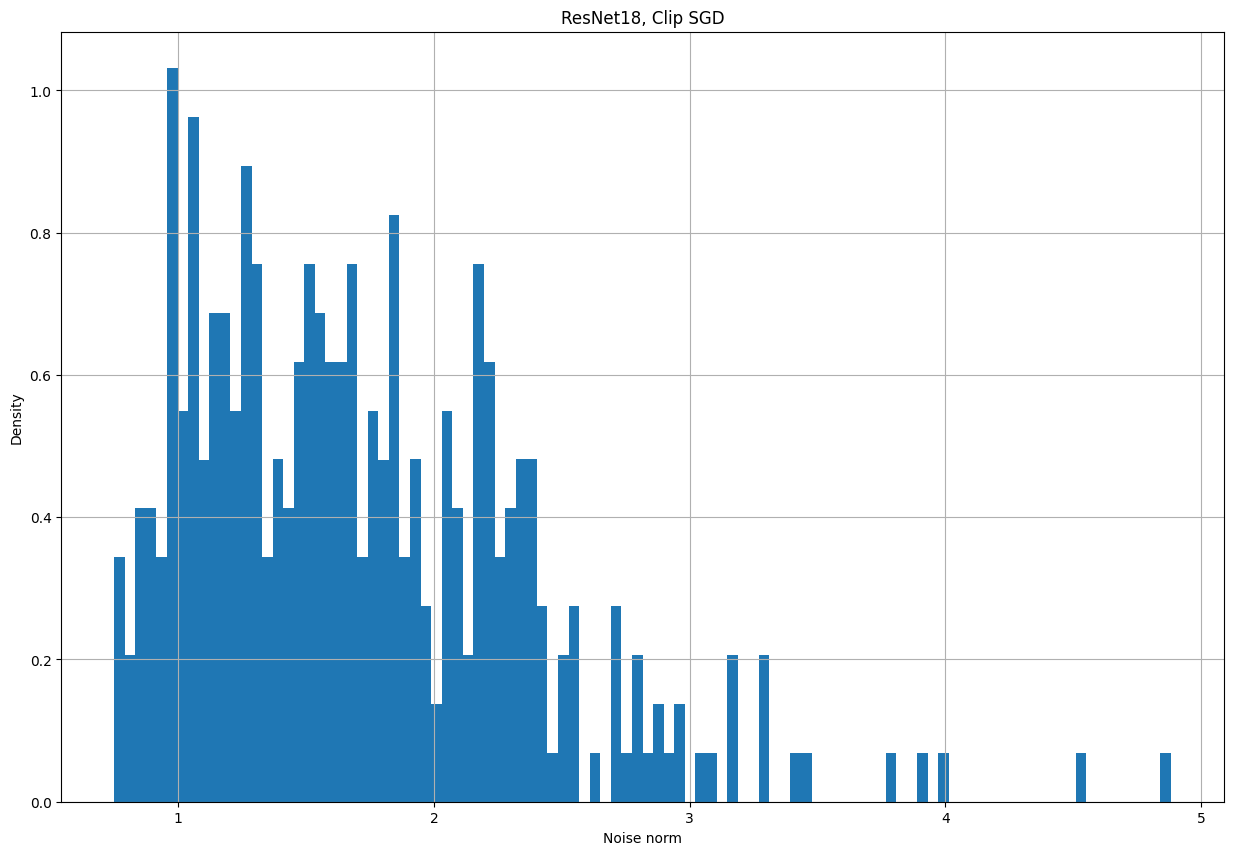

In [69]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_clip_sgd, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('ResNet18, Clip SGD')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

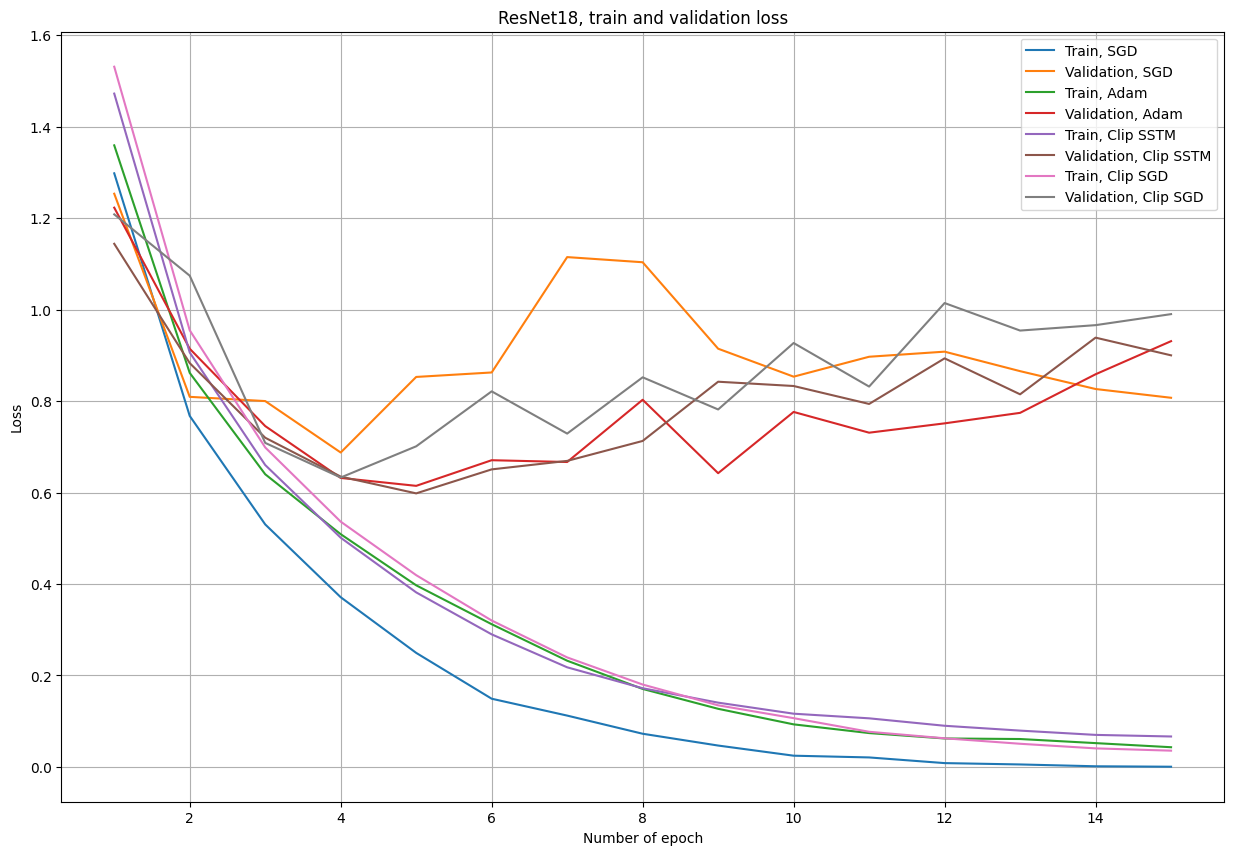

In [70]:
plt.figure(figsize=(15, 10))
plt.title('ResNet18, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(15) + 1
plt.plot(epochs, cb_sgd.train_losses, label='Train, SGD')
plt.plot(epochs, cb_sgd.val_losses, label='Validation, SGD')
plt.plot(epochs, cb_adam.train_losses, label='Train, Adam')
plt.plot(epochs, cb_adam.val_losses, label='Validation, Adam')
plt.plot(epochs, cb_clip_sstm.train_losses, label='Train, Clip SSTM')
plt.plot(epochs, cb_clip_sstm.val_losses, label='Validation, Clip SSTM')
plt.plot(epochs, cb_clip_sgd.train_losses, label='Train, Clip SGD')
plt.plot(epochs, cb_clip_sgd.val_losses, label='Validation, Clip SGD')
plt.legend()
plt.grid(True)

In [71]:
print(f'Best loss on train, SGD: {np.min(cb_sgd.train_losses)}, on {np.argmin(cb_sgd.train_losses) + 1} epoch')
print(f'Best loss on validation, SGD: {np.min(cb_sgd.val_losses)}, on {np.argmin(cb_sgd.val_losses) + 1} epoch')
print(f'Best loss on train, Adam: {np.min(cb_adam.train_losses)}, on {np.argmin(cb_adam.train_losses) + 1} epoch')
print(f'Best loss on validation, Adam: {np.min(cb_adam.val_losses)}, on {np.argmin(cb_adam.val_losses) + 1} epoch')
print(f'Best loss on train, Clip SSTM: {np.min(cb_clip_sstm.train_losses)}, on {np.argmin(cb_clip_sstm.train_losses) + 1} epoch')
print(f'Best loss on validation, Clip SSTM: {np.min(cb_clip_sstm.val_losses)}, on {np.argmin(cb_clip_sstm.val_losses) + 1} epoch')
print(f'Best loss on train, Clip SGD: {np.min(cb_clip_sgd.train_losses)}, on {np.argmin(cb_clip_sgd.train_losses) + 1} epoch')
print(f'Best loss on validation, Clip SGD: {np.min(cb_clip_sgd.val_losses)}, on {np.argmin(cb_clip_sgd.val_losses) + 1} epoch')

Best loss on train, SGD: 0.0005289444248088532, on 15 epoch
Best loss on validation, SGD: 0.6874434947967529, on 4 epoch
Best loss on train, Adam: 0.043156259877814185, on 15 epoch
Best loss on validation, Adam: 0.6145798563957214, on 5 epoch
Best loss on train, Clip SSTM: 0.06663530253304376, on 15 epoch
Best loss on validation, Clip SSTM: 0.5981256365776062, on 5 epoch
Best loss on train, Clip SGD: 0.03564076338774628, on 15 epoch
Best loss on validation, Clip SGD: 0.6328001618385315, on 4 epoch


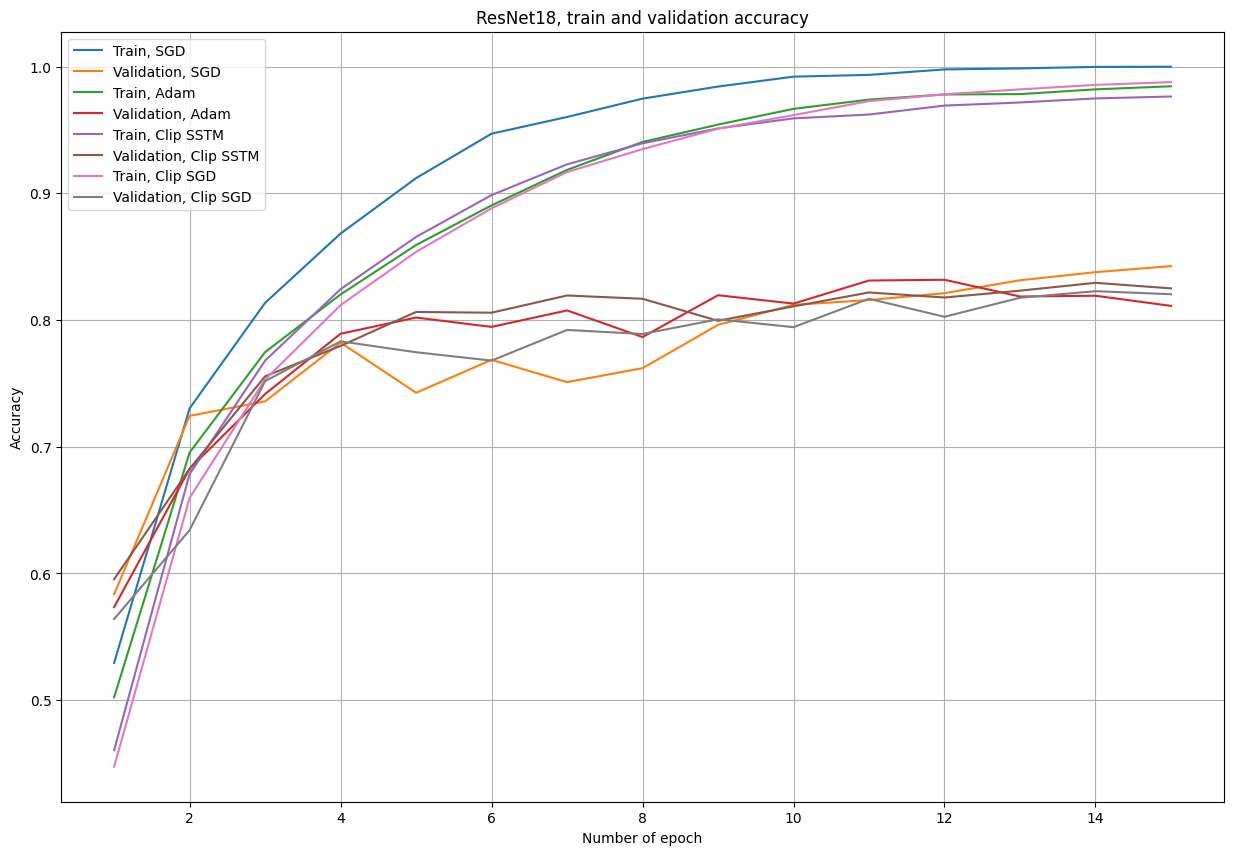

In [72]:
plt.figure(figsize=(15, 10))
plt.title('ResNet18, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(15) + 1
plt.plot(epochs, cb_sgd.train_accs, label='Train, SGD')
plt.plot(epochs, cb_sgd.val_accs, label='Validation, SGD')
plt.plot(epochs, cb_adam.train_accs, label='Train, Adam')
plt.plot(epochs, cb_adam.val_accs, label='Validation, Adam')
plt.plot(epochs, cb_clip_sstm.train_accs, label='Train, Clip SSTM')
plt.plot(epochs, cb_clip_sstm.val_accs, label='Validation, Clip SSTM')
plt.plot(epochs, cb_clip_sgd.train_accs, label='Train, Clip SGD')
plt.plot(epochs, cb_clip_sgd.val_accs, label='Validation, Clip SGD')

plt.legend()
plt.grid(True)

In [73]:
print(f'Best accuracy on train, SGD: {np.max(cb_sgd.train_accs)}, on {np.argmax(cb_sgd.train_accs) + 1} epoch')
print(f'Best accuracy on validation, SGD: {np.max(cb_sgd.val_accs)}, on {np.argmax(cb_sgd.val_accs) + 1} epoch')
print(f'Best accuracy on train, Adam: {np.max(cb_adam.train_accs)}, on {np.argmax(cb_adam.train_accs) + 1} epoch')
print(f'Best accuracy on validation, Adam: {np.max(cb_adam.val_accs)}, on {np.argmax(cb_adam.val_accs) + 1} epoch')
print(f'Best accuracy on train, Clip SSTM: {np.max(cb_clip_sstm.train_accs)}, on {np.argmax(cb_clip_sstm.train_accs) + 1} epoch')
print(f'Best accuracy on validation, Clip SSTM: {np.max(cb_clip_sstm.val_accs)}, on {np.argmax(cb_clip_sstm.val_accs) + 1} epoch')
print(f'Best accuracy on train, Clip SGD: {np.max(cb_clip_sgd.train_accs)}, on {np.argmax(cb_clip_sgd.train_accs) + 1} epoch')
print(f'Best accuracy on validation, Clip SGD: {np.max(cb_clip_sgd.val_accs)}, on {np.argmax(cb_clip_sgd.val_accs) + 1} epoch')

Best accuracy on train, SGD: 0.9999777777777777, on 15 epoch
Best accuracy on validation, SGD: 0.8426, on 15 epoch
Best accuracy on train, Adam: 0.9845333333333334, on 15 epoch
Best accuracy on validation, Adam: 0.8318, on 12 epoch
Best accuracy on train, Clip SSTM: 0.9764666666666667, on 15 epoch
Best accuracy on validation, Clip SSTM: 0.8294, on 14 epoch
Best accuracy on train, Clip SGD: 0.9878222222222223, on 15 epoch
Best accuracy on validation, Clip SGD: 0.8228, on 14 epoch


# MobileNet


In [77]:
class Block(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu6(self.bn1(self.conv1(x)))
        out = F.relu6(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu6(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [78]:
model = MobileNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
cb_sgd = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_sgd, n_epochs=15, callback=cb_sgd)
loss_sgd, acc_sgd = evaluate(model, test_loader, loss_fn)
print(f'MobileNet, test loss, SGD: {loss_sgd}')
print(f'MobileNet, test accuracy, SGD: {acc_sgd}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

MobileNet, test loss, SGD: 1.3676203489303589
MobileNet, test accuracy, SGD: 0.6727


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

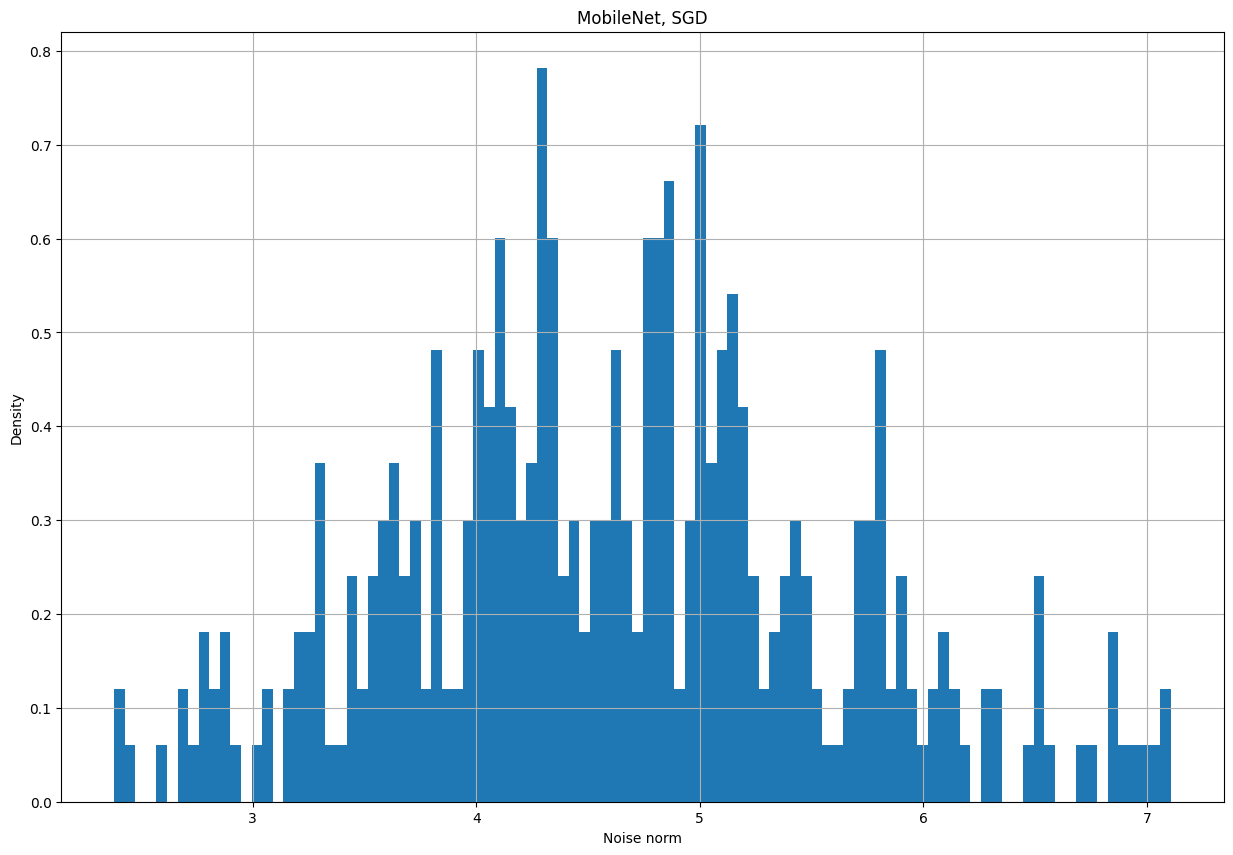

In [79]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_sgd, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('MobileNet, SGD')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

In [80]:
model = MobileNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(model.parameters(), lr=1e-3)
cb_adam = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_adam, n_epochs=15, callback=cb_adam)
loss_adam, acc_adam = evaluate(model, test_loader, loss_fn)
print(f'MobileNet, test loss, Adam: {loss_adam}')
print(f'MobileNet, test accuracy, Adam: {acc_adam}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

MobileNet, test loss, Adam: 1.1094608306884766
MobileNet, test accuracy, Adam: 0.7084


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

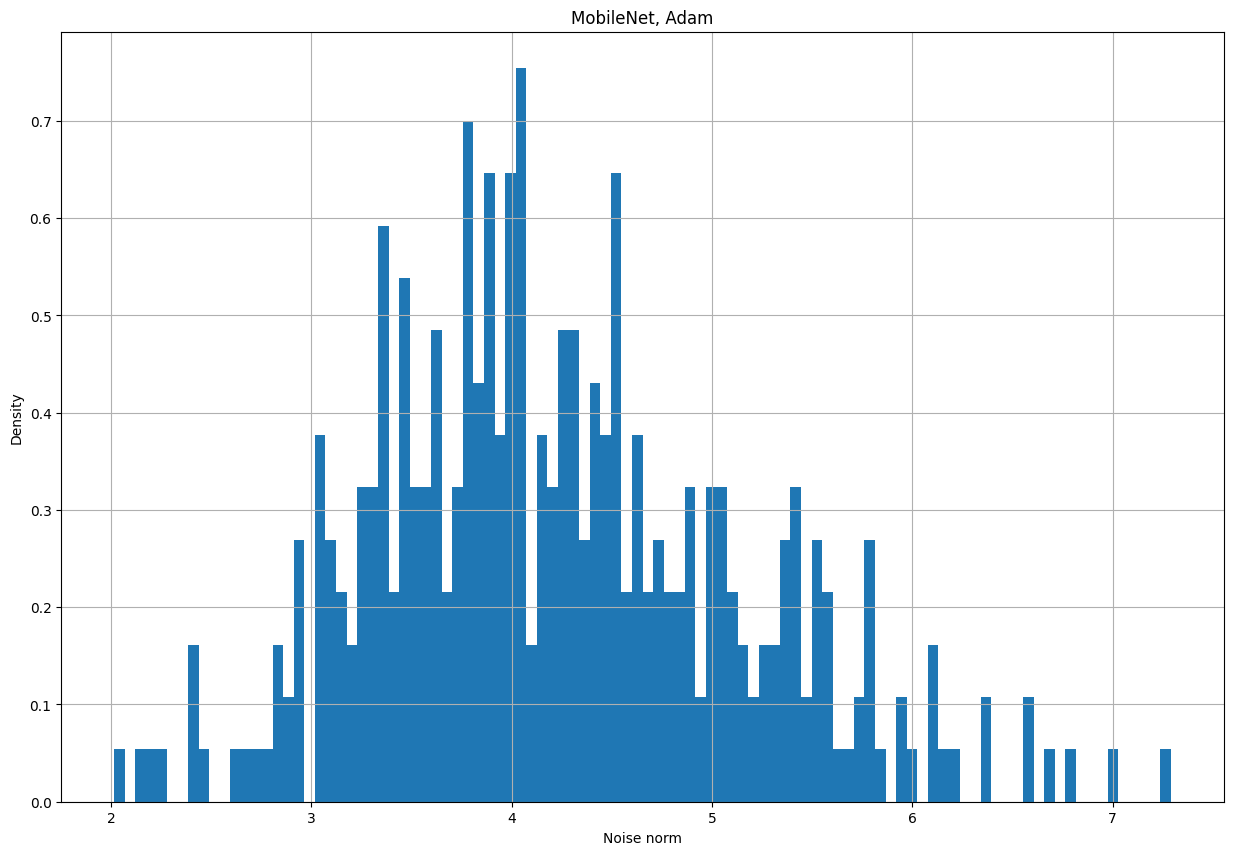

In [81]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_adam, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('MobileNet, Adam')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

In [82]:
model = MobileNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_clip_sstm = clipped_SSTM(model.parameters(), lr=1e-2, L=10, clipping_type='norm', a_k_ratio_upper_bound=0.99)
cb_clip_sstm = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_clip_sstm, n_epochs=15, callback=cb_clip_sstm)
loss_clip_sstm, acc_clip_sstm = evaluate(model, test_loader, loss_fn)
print(f'MobileNet, test loss, Clip SSTM: {loss_clip_sstm}')
print(f'MobileNet, test accuracy, Clip SSTM: {acc_clip_sstm}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

MobileNet, test loss, Clip SSTM: 1.1082953214645386
MobileNet, test accuracy, Clip SSTM: 0.7154


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

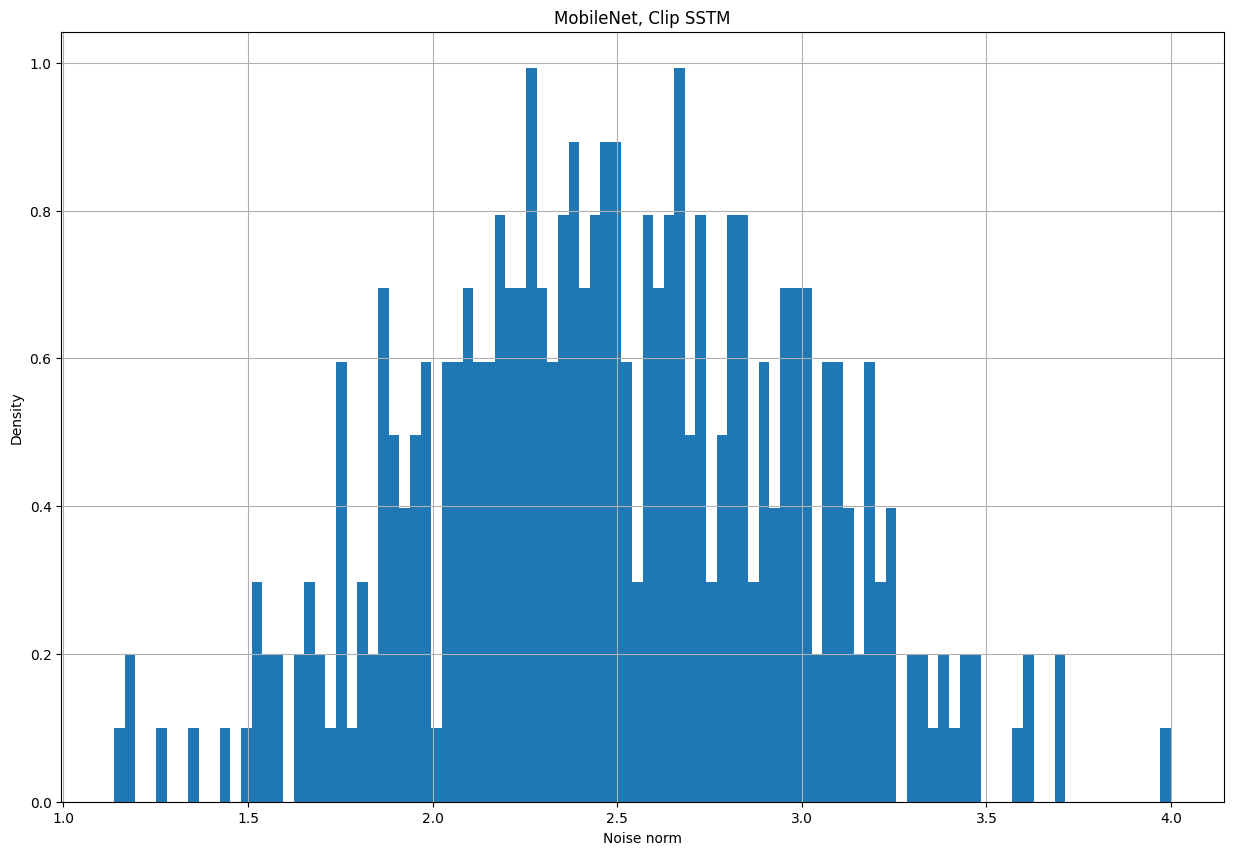

In [83]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_clip_sstm, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('MobileNet, Clip SSTM')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)


In [84]:
model = MobileNet()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss()
optimizer_clip_sgd = clipped_SGD(model.parameters(), lr=5e-2, momentum=0.9, clipping_type="coordinate_wise", clipping_level=0.1)
cb_clip_sgd = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer_clip_sgd, n_epochs=15, callback=cb_clip_sgd)
loss_clip_sgd, acc_clip_sgd = evaluate(model, test_loader, loss_fn)
print(f'MobileNet, test loss, Clip SGD: {loss_clip_sgd}')
print(f'MobileNet, test accuracy, Clip SGD: {acc_clip_sgd}')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

MobileNet, test loss, Clip SGD: 1.0536127090454102
MobileNet, test accuracy, Clip SGD: 0.7559


Computing full gradient


  0%|          | 0/352 [00:00<?, ?it/s]

Computing norm diffs


  0%|          | 0/352 [00:00<?, ?it/s]

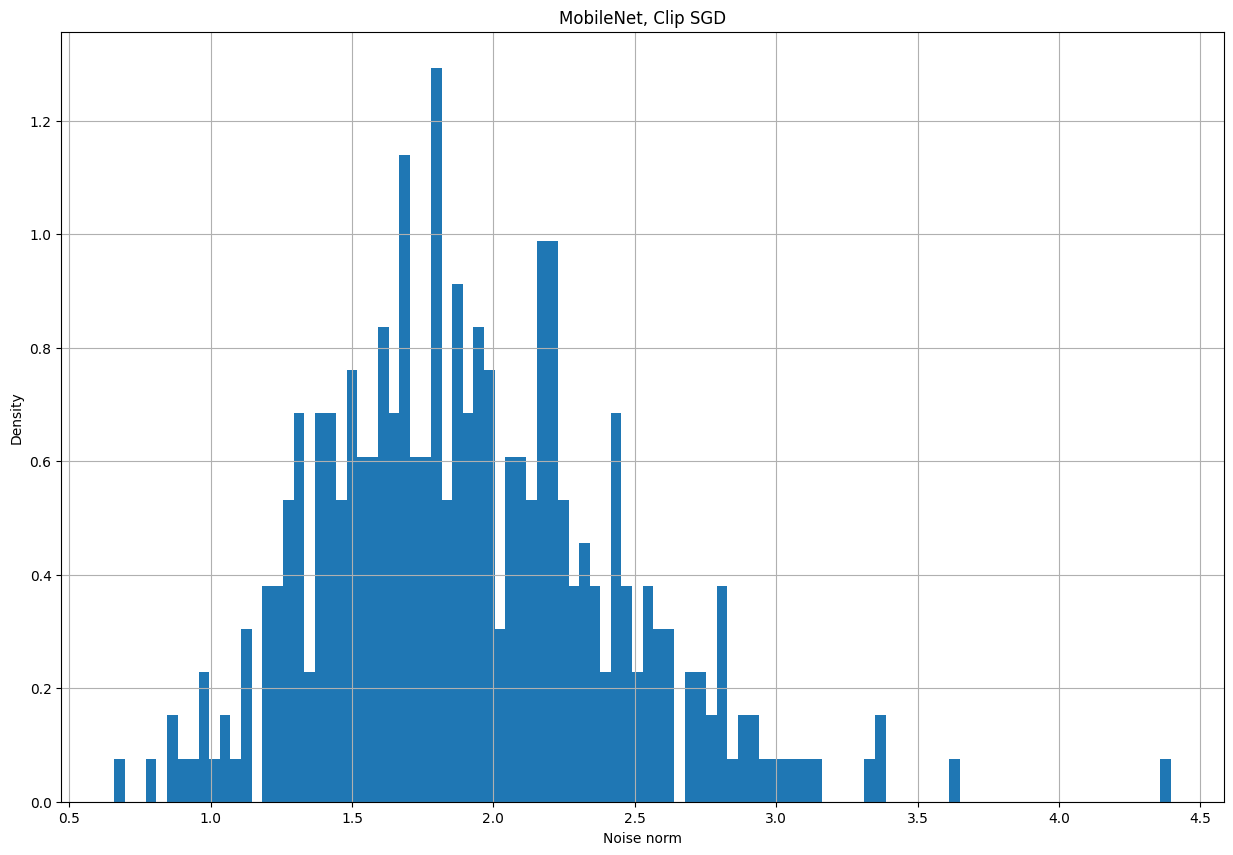

In [85]:
model.eval()
norm_diffs = compute_norm_diffs(model, optimizer_clip_sgd, loss_fn, train_dataloader, train_dataloader)
bins_n = 100
draw_normal = False
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1,1, figure=fig)
axs = []
for i in range(1):
    for j in range(1):
        axs.append(fig.add_subplot(gs[i,j]))

ax = axs[0]
if len(norm_diffs) > 0:
    ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)
    ax.set_title('MobileNet, Clip SGD')
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

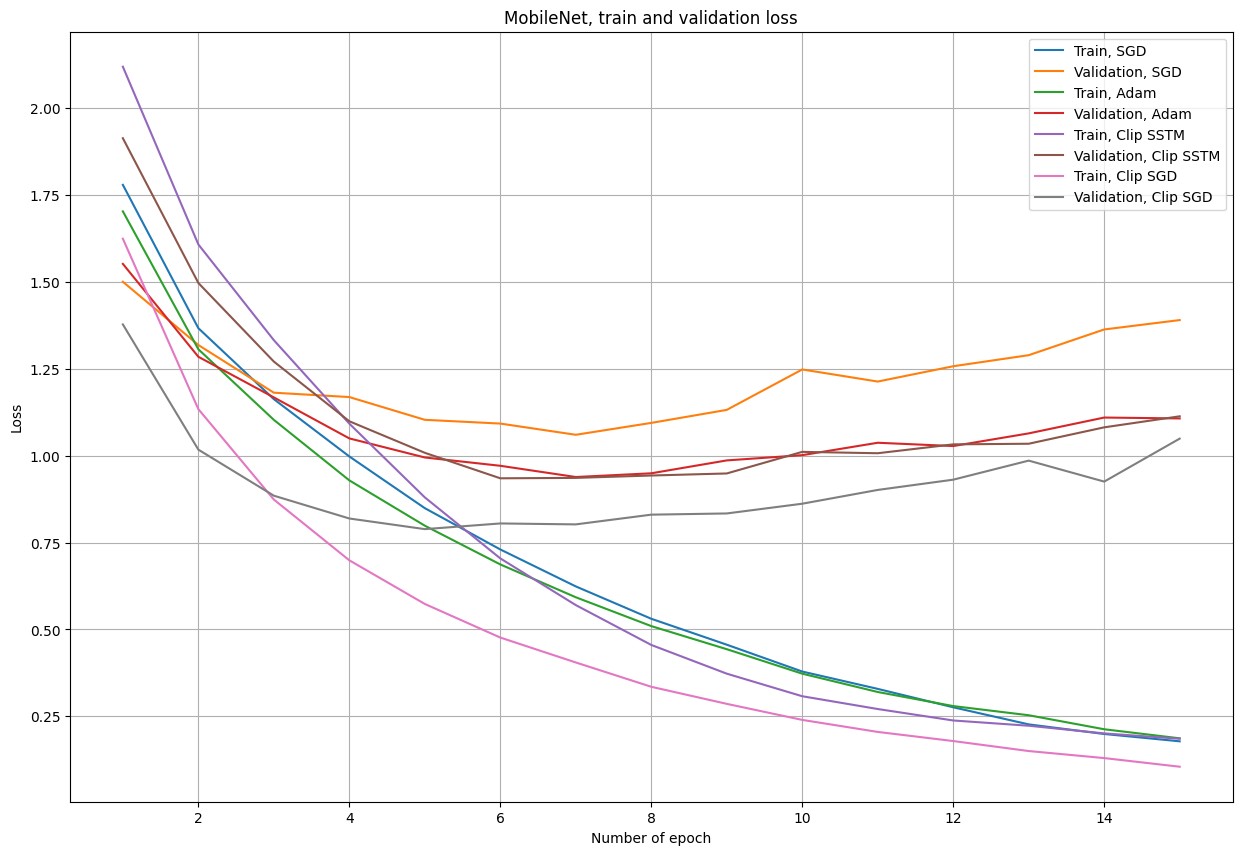

In [86]:
plt.figure(figsize=(15, 10))
plt.title('MobileNet, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(15) + 1
plt.plot(epochs, cb_sgd.train_losses, label='Train, SGD')
plt.plot(epochs, cb_sgd.val_losses, label='Validation, SGD')
plt.plot(epochs, cb_adam.train_losses, label='Train, Adam')
plt.plot(epochs, cb_adam.val_losses, label='Validation, Adam')
plt.plot(epochs, cb_clip_sstm.train_losses, label='Train, Clip SSTM')
plt.plot(epochs, cb_clip_sstm.val_losses, label='Validation, Clip SSTM')
plt.plot(epochs, cb_clip_sgd.train_losses, label='Train, Clip SGD')
plt.plot(epochs, cb_clip_sgd.val_losses, label='Validation, Clip SGD')
plt.legend()
plt.grid(True)

In [87]:
print(f'Best loss on train, SGD: {np.min(cb_sgd.train_losses)}, on {np.argmin(cb_sgd.train_losses) + 1} epoch')
print(f'Best loss on validation, SGD: {np.min(cb_sgd.val_losses)}, on {np.argmin(cb_sgd.val_losses) + 1} epoch')
print(f'Best loss on train, Adam: {np.min(cb_adam.train_losses)}, on {np.argmin(cb_adam.train_losses) + 1} epoch')
print(f'Best loss on validation, Adam: {np.min(cb_adam.val_losses)}, on {np.argmin(cb_adam.val_losses) + 1} epoch')
print(f'Best loss on train, Clip SSTM: {np.min(cb_clip_sstm.train_losses)}, on {np.argmin(cb_clip_sstm.train_losses) + 1} epoch')
print(f'Best loss on validation, Clip SSTM: {np.min(cb_clip_sstm.val_losses)}, on {np.argmin(cb_clip_sstm.val_losses) + 1} epoch')
print(f'Best loss on train, Clip SGD: {np.min(cb_clip_sgd.train_losses)}, on {np.argmin(cb_clip_sgd.train_losses) + 1} epoch')
print(f'Best loss on validation, Clip SGD: {np.min(cb_clip_sgd.val_losses)}, on {np.argmin(cb_clip_sgd.val_losses) + 1} epoch')

Best loss on train, SGD: 0.17818101397090488, on 15 epoch
Best loss on validation, SGD: 1.0602271556854248, on 7 epoch
Best loss on train, Adam: 0.18677930484082964, on 15 epoch
Best loss on validation, Adam: 0.9387019276618958, on 7 epoch
Best loss on train, Clip SSTM: 0.18552761300404866, on 15 epoch
Best loss on validation, Clip SSTM: 0.9350192546844482, on 6 epoch
Best loss on train, Clip SGD: 0.10506578736040327, on 15 epoch
Best loss on validation, Clip SGD: 0.7887779474258423, on 5 epoch


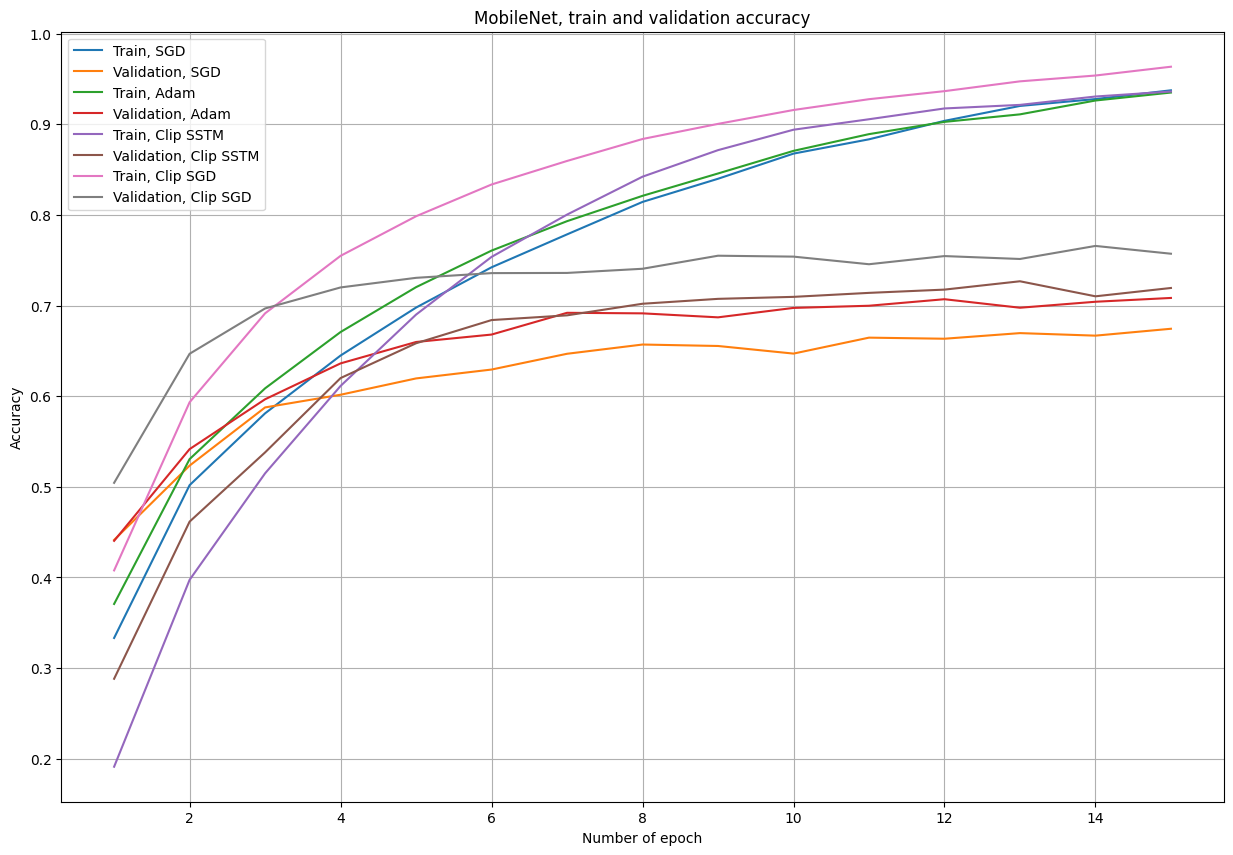

In [88]:
plt.figure(figsize=(15, 10))
plt.title('MobileNet, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(15) + 1
plt.plot(epochs, cb_sgd.train_accs, label='Train, SGD')
plt.plot(epochs, cb_sgd.val_accs, label='Validation, SGD')
plt.plot(epochs, cb_adam.train_accs, label='Train, Adam')
plt.plot(epochs, cb_adam.val_accs, label='Validation, Adam')
plt.plot(epochs, cb_clip_sstm.train_accs, label='Train, Clip SSTM')
plt.plot(epochs, cb_clip_sstm.val_accs, label='Validation, Clip SSTM')
plt.plot(epochs, cb_clip_sgd.train_accs, label='Train, Clip SGD')
plt.plot(epochs, cb_clip_sgd.val_accs, label='Validation, Clip SGD')

plt.legend()
plt.grid(True)

In [89]:
print(f'Best accuracy on train, SGD: {np.max(cb_sgd.train_accs)}, on {np.argmax(cb_sgd.train_accs) + 1} epoch')
print(f'Best accuracy on validation, SGD: {np.max(cb_sgd.val_accs)}, on {np.argmax(cb_sgd.val_accs) + 1} epoch')
print(f'Best accuracy on train, Adam: {np.max(cb_adam.train_accs)}, on {np.argmax(cb_adam.train_accs) + 1} epoch')
print(f'Best accuracy on validation, Adam: {np.max(cb_adam.val_accs)}, on {np.argmax(cb_adam.val_accs) + 1} epoch')
print(f'Best accuracy on train, Clip SSTM: {np.max(cb_clip_sstm.train_accs)}, on {np.argmax(cb_clip_sstm.train_accs) + 1} epoch')
print(f'Best accuracy on validation, Clip SSTM: {np.max(cb_clip_sstm.val_accs)}, on {np.argmax(cb_clip_sstm.val_accs) + 1} epoch')
print(f'Best accuracy on train, Clip SGD: {np.max(cb_clip_sgd.train_accs)}, on {np.argmax(cb_clip_sgd.train_accs) + 1} epoch')
print(f'Best accuracy on validation, Clip SGD: {np.max(cb_clip_sgd.val_accs)}, on {np.argmax(cb_clip_sgd.val_accs) + 1} epoch')

Best accuracy on train, SGD: 0.9375111111111111, on 15 epoch
Best accuracy on validation, SGD: 0.6744, on 15 epoch
Best accuracy on train, Adam: 0.9350444444444445, on 15 epoch
Best accuracy on validation, Adam: 0.7084, on 15 epoch
Best accuracy on train, Clip SSTM: 0.9361555555555555, on 15 epoch
Best accuracy on validation, Clip SSTM: 0.7268, on 13 epoch
Best accuracy on train, Clip SGD: 0.9635333333333334, on 15 epoch
Best accuracy on validation, Clip SGD: 0.7658, on 14 epoch
